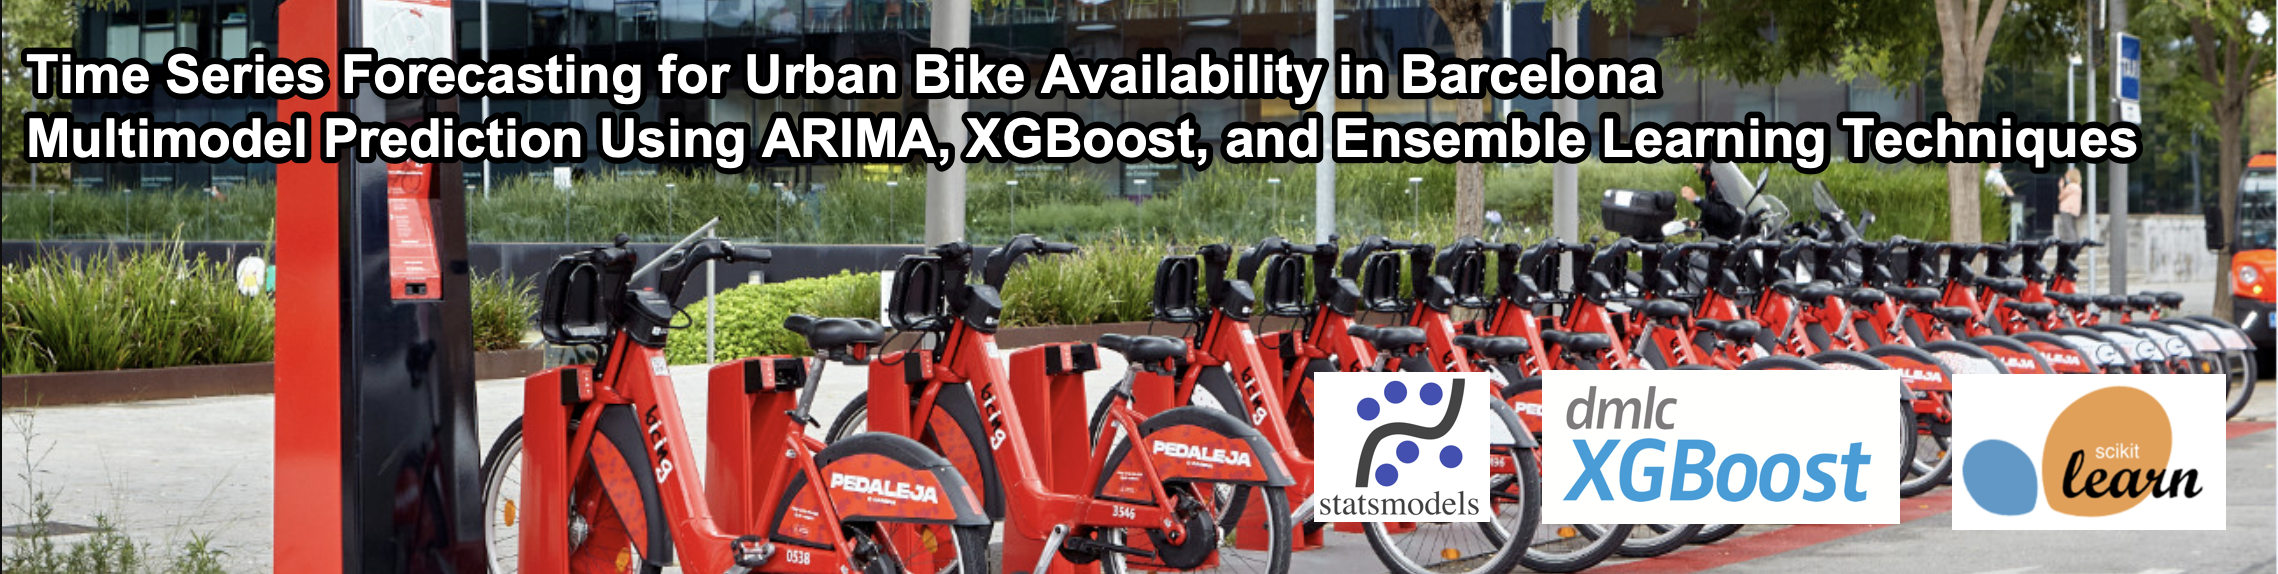


This dataset contains 250 million rows of information from the ~500 bike stations of the Barcelona public bicycle sharing service. The data consists in time series information of the electric and mechanical bicycles available every 4 minutes aprox., from March 2019 to March 2024.
The original data has some different errors, few of them have been already corrected but there are still some missing values, columns with wrong data types and other fewer artifacts or missing data.

For memory constraints issues and CPU bound limitations, the dataset has been resampled to an hourly frequency. Resampling to a fixed frequency ( e.g. hourly) can help reduce the number of outliers, fill missing values and gaps in the time series, and overall uniformize the time series dataset.

Every month's information is separated in a different file as {year}_{month}_STATIONS.csv. Then the metadata info of every station has been simplified and compressed in the {year}_INFO.csv files where there is a single entry for every station and day, separated in a different file for every year.


The data is collected from the public BCN Open Data website, which is available for everyone (some resources need from creating a free account and token):

    Stations data: https://opendata-ajuntament.barcelona.cat/data/en/dataset/estat-estacions-bicing
    Stations info: https://opendata-ajuntament.barcelona.cat/data/en/dataset/informacio-estacions-bicing

You can find more information in them.

## STEP 1: Integrate all historical data from the station datasets 

In [1]:
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import holidays
import math
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import folium
from folium.plugins import MarkerCluster

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sel_cols = ["date", "station_id", "num_bikes_available", "num_bikes_available_types.mechanical", 
            "num_bikes_available_types.ebike", "num_docks_available", "is_renting", "last_reported"]

#time period
start_year = 2021
end_year = 2021


all_stations_data = []
all_files = os.listdir()

for filename in tqdm(all_files):
    if filename.endswith("STATIONS_hourly_mean.csv"):
        try:
            year = int(filename.split("_")[0])
            month = int(filename.split("_")[1])
            if start_year <= year <= end_year:
                station_df = pd.read_csv(
                    filename,
                    usecols=sel_cols,
                )
                station_df['date'] = pd.to_datetime(station_df['date'], format='%Y-%m-%d %H:%M:%S')
                station_df = station_df[station_df['date'].dt.year >= start_year]
                all_stations_data.append(station_df)
        except (IndexError, ValueError):
            continue

combined_stations_df = pd.concat(all_stations_data, ignore_index=True)
combined_stations_df.sort_values(by=['date', 'station_id'], inplace=True)

100%|█████████████████████████████████████████████████| 74/74 [00:03<00:00, 23.51it/s]


In [6]:
combined_stations_df

date  station_id  num_bikes_available  \
3700040 2021-01-01 00:00:00           1                   40   
3700783 2021-01-01 00:00:00           2                   13   
3701526 2021-01-01 00:00:00           3                    5   
3702269 2021-01-01 00:00:00           4                   12   
3703012 2021-01-01 00:00:00           5                    9   
...                     ...         ...                  ...   
2585938 2021-12-31 23:00:00         515                    1   
2586684 2021-12-31 23:00:00         516                   10   
2587430 2021-12-31 23:00:00         517                    3   
2588176 2021-12-31 23:00:00         518                    6   
2588922 2021-12-31 23:00:00         519                    1   

         num_bikes_available_types.mechanical  \
3700040                                    40   
3700783                                    13   
3701526                                     3   
3702269                                    12   
3703012                                     8   
...                                       ...   
2585938                                     1   
2586684                                     7   
2587430                                     1   
2588176                                     2   
2588922                                     0   

         num_bikes_available_types.ebike  num_docks_available  is_renting  \
3700040                                0                    5         1.0   
3700783                                0                   13         1.0   
3701526                                2                   20         1.0   
3702269                                0                    8         1.0   
3703012                                1                   29         1.0   
...                                  ...                  ...         ...   
2585938                                0                   22         1.0   
2586684                                3                   10         1.0   
2587430                                2                   17         1.0   
2588176                                4                   21         1.0   
2588922                                1                   22         1.0   

         last_reported  
3700040   1.609459e+09  
3700783   1.609459e+09  
3701526   1.609459e+09  
3702269   1.609459e+09  
3703012   1.609459e+09  
...                ...  
2585938   1.640992e+09  
2586684   1.640992e+09  
2587430   1.640992e+09  
2588176   1.640992e+09  
2588922   1.640992e+09  

[4453662 rows x 8 columns]

In [7]:
# Load station information from YEAR_INFO.csv files
def load_station_info(data_path, start_year, end_year):
    station_info_files = [f for f in os.listdir(data_path) if f.endswith("INFO.csv")]
    all_station_info = []
    
    for filename in station_info_files:
        year = int(filename.split("_")[0])
        if start_year <= year <= end_year:
            station_info_df = pd.read_csv(data_path / filename)
            all_station_info.append(station_info_df)
    combined_station_info = pd.concat(all_station_info, ignore_index=True)
    
    combined_station_info.drop_duplicates(subset=["station_id"], inplace=True)
    
    return combined_station_info

# Load station info for the specified time period
DATA_PATH = Path.cwd()
station_info_df = load_station_info(DATA_PATH, start_year, end_year)

In [8]:
station_info_df

Unnamed: 0  station_id        date  \
0                0           1  2021-01-01   
31              31           2  2021-01-01   
62              62           3  2021-01-01   
93              93           4  2021-01-01   
124            124           5  2021-01-01   
...            ...         ...         ...   
17047        17047          52  2021-02-23   
18089        18089          91  2021-02-05   
28417        28417         467  2021-02-11   
124894      124894         520  2021-08-13   
124895      124895         529  2021-08-16   

                                       name physical_configuration        lat  \
0             GRAN VIA CORTS CATALANES, 760    ELECTRICBIKESTATION  41.397978   
31                    C/ ROGER DE FLOR, 126    ELECTRICBIKESTATION  41.395488   
62                            C/ NÀPOLS, 82    ELECTRICBIKESTATION  41.394156   
93                             C/ RIBES, 13    ELECTRICBIKESTATION  41.393317   
124     PG. LLUIS COMPANYS, 11 (ARC TRIOMF)    ELECTRICBIKESTATION  41.391103   
...                                     ...                    ...        ...   
17047                    PL. SANT MIQUEL, 4    ELECTRICBIKESTATION  41.381169   
18089                 C/ COMTE D'URGELL, 43    ELECTRICBIKESTATION  41.381250   
28417                    PL. JESÚS CARRASCO    ELECTRICBIKESTATION  41.445046   
124894                   TALLER R. BARRADAS    ELECTRICBIKESTATION  41.347695   
124895                         Nassos - 529                  VALET  41.347768   

             lon  altitude                              address  post_code  \
0       2.180107        16        GRAN VIA CORTS CATALANES, 760       8013   
31      2.177198        17                C/ ROGER DE FLOR, 126       8013   
62      2.181331        11                        C/ NÀPOLS, 82       8013   
93      2.181248         8                         C/ RIBES, 13       8013   
124     2.180176         7  PG. LLUIS COMPANYS, 11 (ARC TRIOMF)       8018   
...          ...       ...                                  ...        ...   
17047   2.177333         0                   PL. SANT MIQUEL, 4       8908   
18089   2.159474        16                C/ COMTE D'URGELL, 43       8011   
28417   2.176726        93                   PL. JESÚS CARRASCO       8042   
124894  2.119480         0                   TALLER R. BARRADAS       8908   
124895  2.119389         7                               Nassos          1   

        capacity  nearby_distance cross_street  last_updated  ttl  
0             46             1000          NaN    1609455629   25  
31            27             1000          NaN    1609455629   25  
62            27             1000          NaN    1609455629   25  
93            21             1000          NaN    1609455629   25  
124           39             1000          NaN    1609455629   25  
...          ...              ...          ...           ...  ...  
17047         32             1000          NaN    1614082846   30  
18089         35             1000          NaN    1612558532   20  
28417         20             1000          NaN    1613055344   30  
124894        16             1000          NaN    1628849085    6  
124895         1                1  Tablet OSIT    1629108889    8  

[511 rows x 15 columns]

## STEP 2: Merge weather data into station data time series

In this tep, we will add weather variables such as hourly temperature (ºC) or total precipitation (mm) to aid in our feature engineering efforts. You can use free of sign up subscription tools like https://github.com/meteostat/meteostat-python to retrieve local weather data that fetches the most nearby station to your local point. Alternatively, you can request an API key to AEMET: https://opendata.aemet.es/centrodedescargas/obtencionAPIKey (Among others, but AEMET is quite automatic) and access their observational and historical climate data for weather stations across Spain. Be aware that this services have limited API requests when pulling historical data.
                                                                                                                                           

In [10]:
!pip install meteostat

In [11]:
from meteostat import Point, Hourly, Stations
from datetime import datetime

start_date = datetime(start_year, 1, 1)
end_date = datetime(end_year, 12, 31, 23, 59)

# Plaça de Catalunya
barcelona_center = [41.3870, 2.1700] # lat,lon  

def fetch_hourly_weather_data(center_point, start_date, end_date):
    stations = Stations().nearby(center_point[0], center_point[1], 50000)  # Search within 10 km radius
    station = stations.fetch(2)  # Fetch the nearest 2 station
    if len(station) > 0:
        # MAIN BARCELONA CITY STATION HAS NO HOURLY DATA!
        weather_data = Hourly(station.index[1], start_date, end_date).fetch()
        return weather_data[['temp', 'prcp']] 
    else:
        return None

weather_data = fetch_hourly_weather_data(barcelona_center, start_date, end_date)
weather_data['temp'].fillna(method='ffill', inplace=True)  # Forward fill missing temperatures
weather_data['prcp'].fillna(0, inplace=True)  # Fill missing precipitation with 0
weather_data.reset_index(inplace=True)
weather_data.rename(columns={'time': 'date'}, inplace=True)


# Merge if you want, becareful when having multiple station id because there will be duplicate 
merged_df = pd.merge(combined_stations_df, weather_data, on='date', how='left')

In [12]:
merged_df

date  station_id  num_bikes_available  \
0       2021-01-01 00:00:00           1                   40   
1       2021-01-01 00:00:00           2                   13   
2       2021-01-01 00:00:00           3                    5   
3       2021-01-01 00:00:00           4                   12   
4       2021-01-01 00:00:00           5                    9   
...                     ...         ...                  ...   
4453657 2021-12-31 23:00:00         515                    1   
4453658 2021-12-31 23:00:00         516                   10   
4453659 2021-12-31 23:00:00         517                    3   
4453660 2021-12-31 23:00:00         518                    6   
4453661 2021-12-31 23:00:00         519                    1   

         num_bikes_available_types.mechanical  \
0                                          40   
1                                          13   
2                                           3   
3                                          12   
4                                           8   
...                                       ...   
4453657                                     1   
4453658                                     7   
4453659                                     1   
4453660                                     2   
4453661                                     0   

         num_bikes_available_types.ebike  num_docks_available  is_renting  \
0                                      0                    5         1.0   
1                                      0                   13         1.0   
2                                      2                   20         1.0   
3                                      0                    8         1.0   
4                                      1                   29         1.0   
...                                  ...                  ...         ...   
4453657                                0                   22         1.0   
4453658                                3                   10         1.0   
4453659                                2                   17         1.0   
4453660                                4                   21         1.0   
4453661                                1                   22         1.0   

         last_reported  temp  prcp  
0         1.609459e+09   8.2   0.0  
1         1.609459e+09   8.2   0.0  
2         1.609459e+09   8.2   0.0  
3         1.609459e+09   8.2   0.0  
4         1.609459e+09   8.2   0.0  
...                ...   ...   ...  
4453657   1.640992e+09  10.7   0.0  
4453658   1.640992e+09  10.7   0.0  
4453659   1.640992e+09  10.7   0.0  
4453660   1.640992e+09  10.7   0.0  
4453661   1.640992e+09  10.7   0.0  

[4453662 rows x 10 columns]

#### STEP 3: Feature Engineering


#### 3.1 First, let's look at single station from barcelona and understand the data that we have

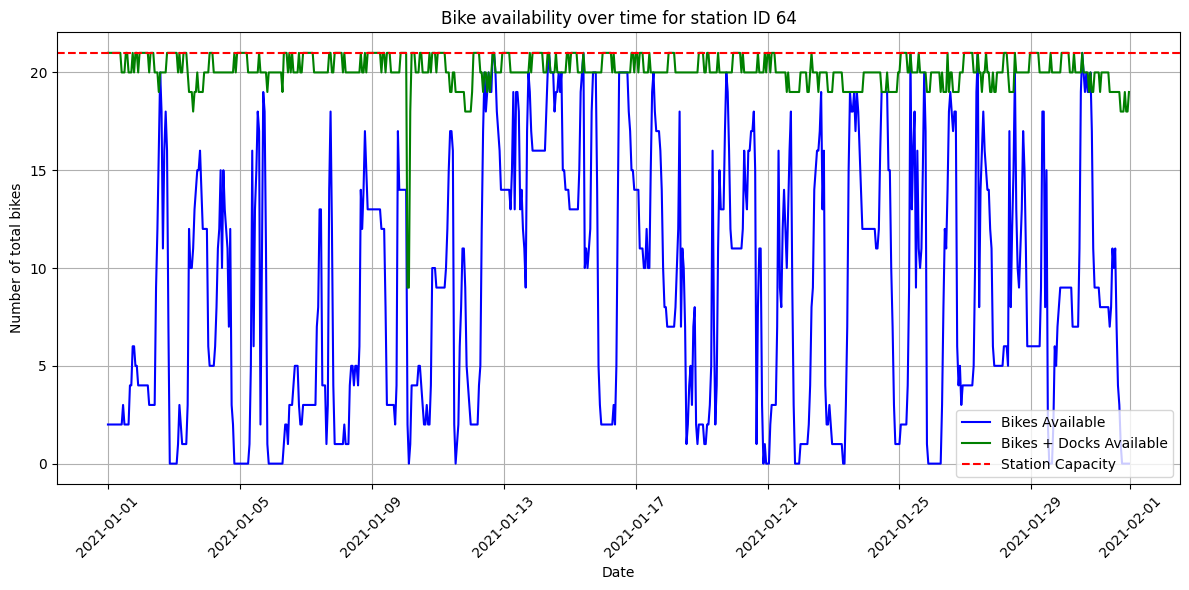

In [15]:
import matplotlib.pyplot as plt


def filter_by_station_id(df, station_id):
    return df[df['station_id'] == station_id]


station_id_to_filter = 64   # Replace with desired station_id
filtered_df = filter_by_station_id(merged_df, station_id_to_filter)


filtered_df['date'] = pd.to_datetime(filtered_df['date'])

target_month = 1  # 1-12
target_year = 2021


monthly_hourly_df = filtered_df[
    (filtered_df['date'].dt.month == target_month) & 
    (filtered_df['date'].dt.year == target_year)
]

# Resample the data to daily frequency and apply aggregation functions
"""
filtered_df.set_index('date', inplace=True)
daily_df = filtered_df.resample('D').agg({
    'num_bikes_available': 'mean',  # Daily average bikes available
    'num_bikes_available_types.mechanical': 'mean',  # Daily average mechanical bikes
    'num_bikes_available_types.ebike': 'mean',  # Daily average e-bikes
    'num_docks_available': 'mean',  # Daily average docks available
    'is_renting': 'max',  # Whether renting was available at any point during the day
    'last_reported': 'max',  # Last reported timestamp for the day
    'temp': 'mean',  # Daily average temperature
    'prcp': 'sum'  # Total precipitation for the day
})
daily_df.reset_index(inplace=True)
"""

station_capacity = station_info_df[station_info_df['station_id'] == station_id_to_filter]['capacity'].values[0]


plt.figure(figsize=(12, 6))
plt.plot(monthly_hourly_df['date'], monthly_hourly_df['num_bikes_available'], label='Bikes Available', color='blue')
plt.plot(monthly_hourly_df['date'], monthly_hourly_df['num_docks_available']+monthly_hourly_df['num_bikes_available'], label='Bikes + Docks Available', color='green')
plt.axhline(y=station_capacity, color='red', linestyle='--', label='Station Capacity')
plt.xlabel('Date')
plt.ylabel('Number of total bikes')
plt.title(f'Bike availability over time for station ID {station_id_to_filter}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.2 Hourly trend plotting

Plot the average bike availability distribution by hour of the day; for a typical weekday vs weekend day. Utilize data from at least 1 month. Use different regions of Barcelona or stations ids to see inter/intra region availability. What do you observe in the hourly trend? Observe bikes flows ( changes in avaiability) across groups of stations, can you infer anything about the bike mobility across the city?

In [19]:
# Define a month and year to analyze
target_month = 7  # July
target_year = 2021

# Filter data for the target month
monthly_data = merged_df[
    (merged_df['date'].dt.month == target_month) & 
    (merged_df['date'].dt.year == target_year)
]

# Add weekday/weekend classification and hour of day
monthly_data['hour'] = monthly_data['date'].dt.hour
monthly_data['is_weekend'] = monthly_data['date'].dt.dayofweek >= 5  # 5 = Saturday, 6 = Sunday

# Define regions based on station IDs (example groups)
# You can modify these regions based on actual geographical information
region_mapping = {
    'Downtown': list(range(1, 100)),
    'Residential': list(range(100, 200)),
    'Tourist': list(range(200, 300)),
    'Business': list(range(300, 400))
}

# Create a new column for region
def assign_region(station_id):
    for region, stations in region_mapping.items():
        if station_id in stations:
            return region
    return 'Other'

monthly_data['region'] = monthly_data['station_id'].apply(assign_region)

# Calculate hourly averages by weekday/weekend and region
hourly_avg_by_day_type = monthly_data.groupby(['hour', 'is_weekend', 'region'])['num_bikes_available'].mean().reset_index()

In [20]:
hourly_avg_by_day_type

hour  is_weekend       region  num_bikes_available
0       0       False     Business             9.370909
1       0       False     Downtown            10.186603
2       0       False        Other             7.904781
3       0       False  Residential            11.006112
4       0       False      Tourist             8.202938
..    ...         ...          ...                  ...
235    23        True     Business             9.294444
236    23        True     Downtown            10.355556
237    23        True        Other             7.666667
238    23        True  Residential            10.575862
239    23        True      Tourist             7.741573

[240 rows x 4 columns]

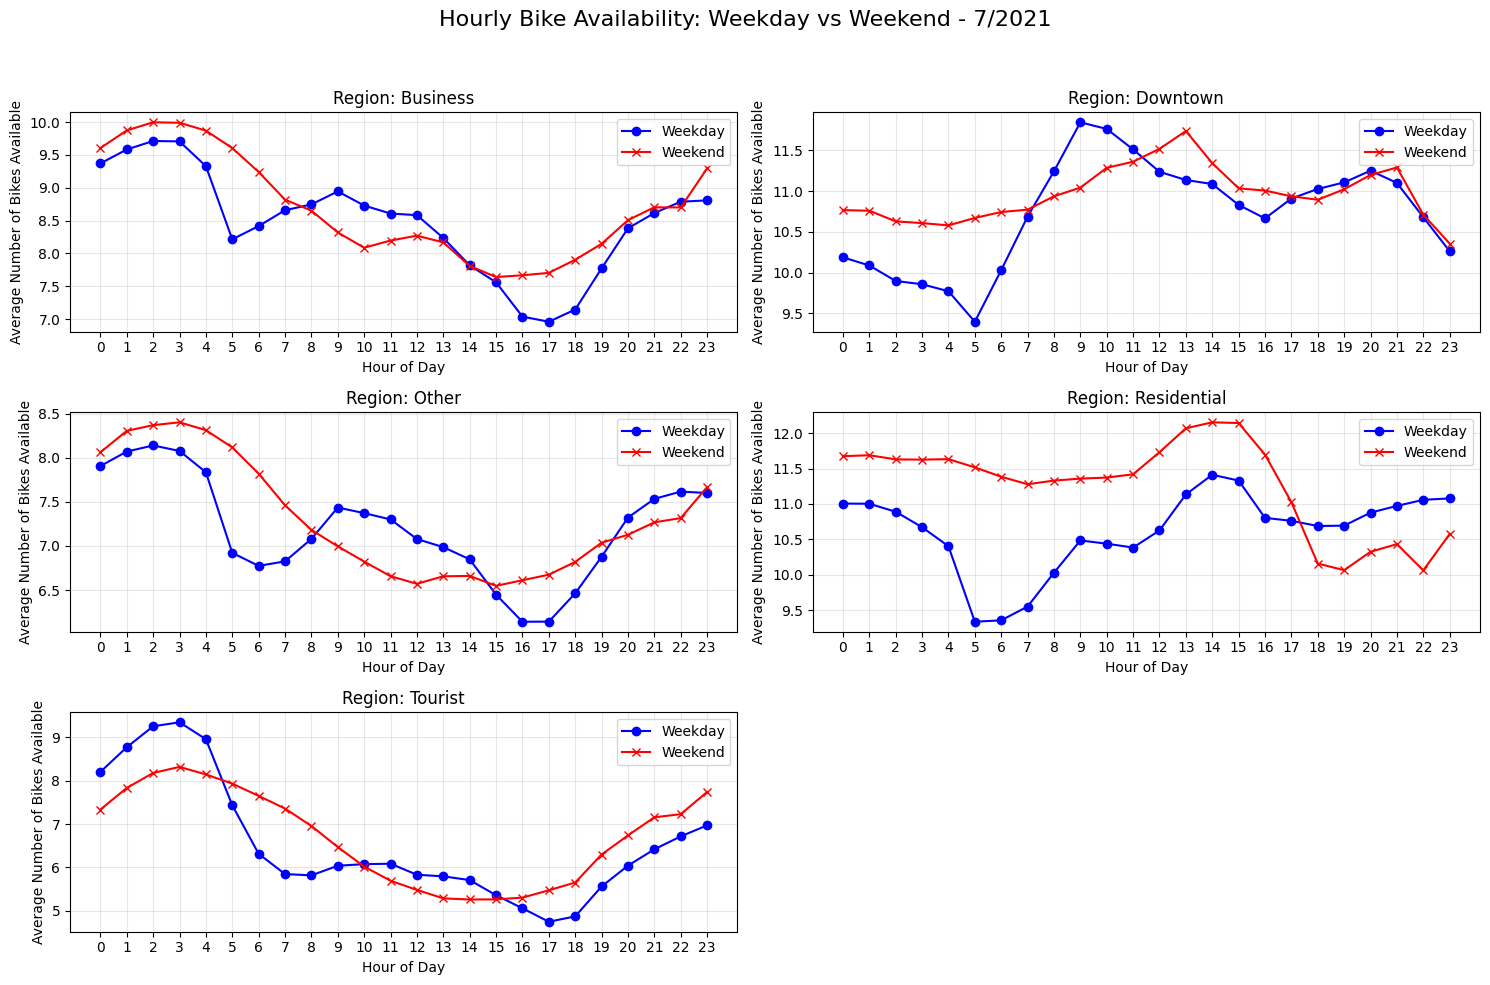

In [23]:
plt.figure(figsize=(15, 10))

for i, region in enumerate(hourly_avg_by_day_type['region'].unique()):
    plt.subplot(3, 2, i+1)  # 3 rows and 2 columns gives you 6 subplots in total
    
    # Filter data for the current region
    region_data = hourly_avg_by_day_type[hourly_avg_by_day_type['region'] == region]
    
    # Plot weekday line
    weekday_data = region_data[region_data['is_weekend'] == False]
    plt.plot(weekday_data['hour'], weekday_data['num_bikes_available'], 
             label='Weekday', color='blue', marker='o')
    
    # Plot weekend line
    weekend_data = region_data[region_data['is_weekend'] == True]
    plt.plot(weekend_data['hour'], weekend_data['num_bikes_available'], 
             label='Weekend', color='red', marker='x')
    
    plt.title(f'Region: {region}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Number of Bikes Available')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.suptitle(f'Hourly Bike Availability: Weekday vs Weekend - {target_month}/{target_year}', 
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


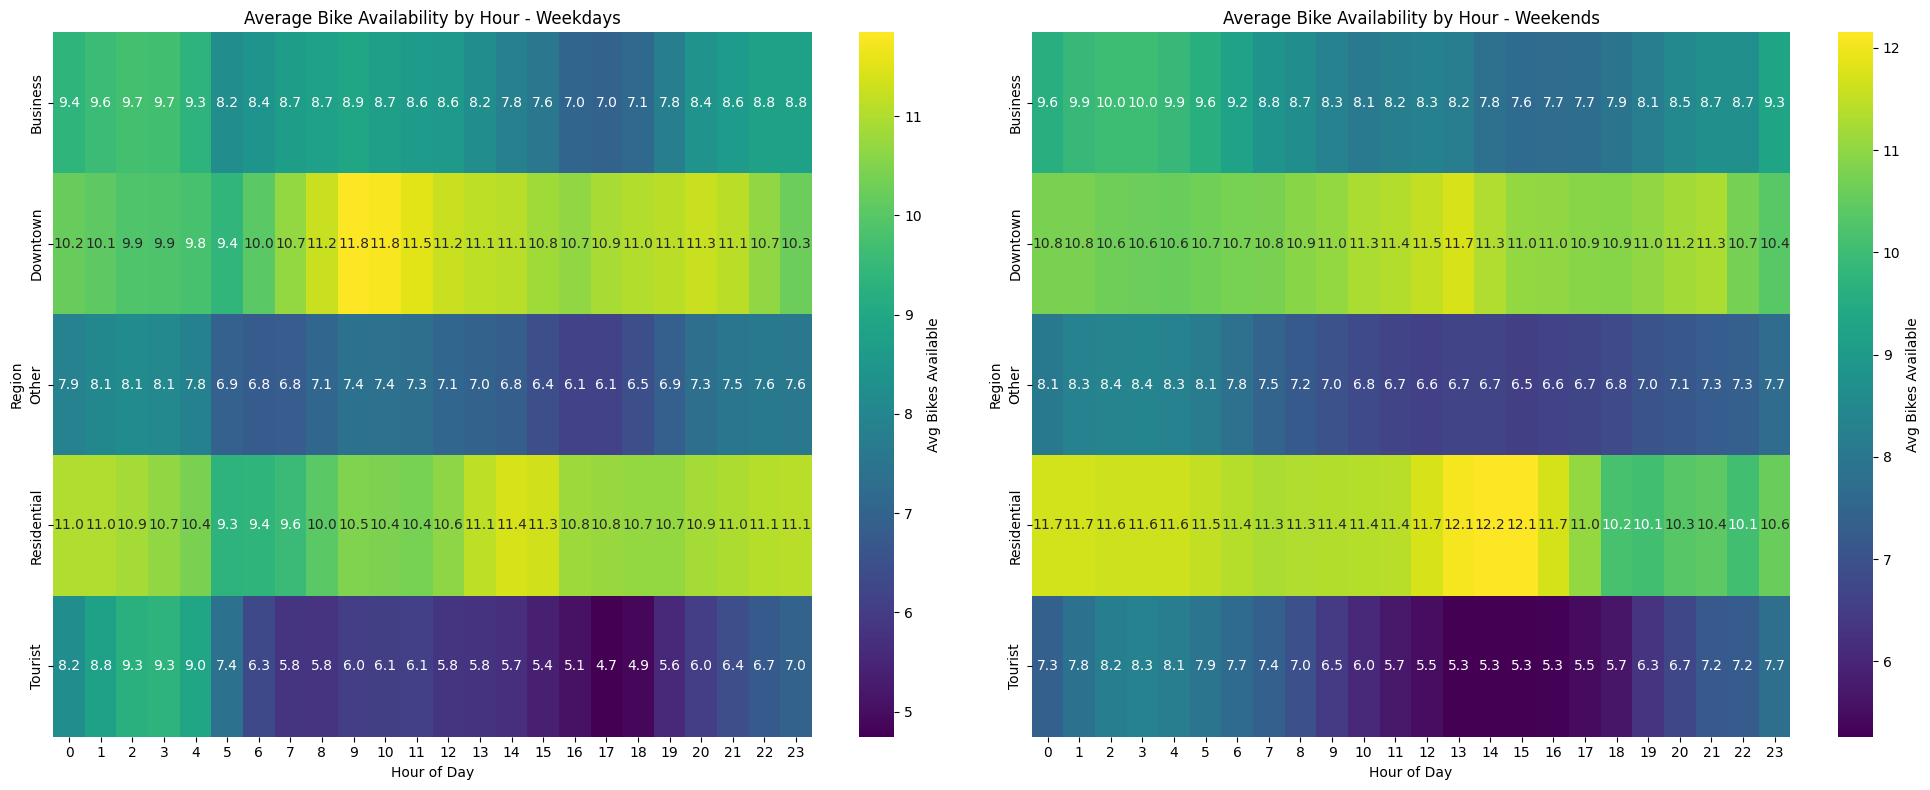

In [24]:
# Alternative visualization: Heatmap of hourly bike availability
plt.figure(figsize=(20, 8))

# Pivot the data for the heatmap
for i, day_type in enumerate(['Weekday', 'Weekend']):
    plt.subplot(1, 2, i+1)
    
    is_weekend = (day_type == 'Weekend')
    heatmap_data = hourly_avg_by_day_type[hourly_avg_by_day_type['is_weekend'] == is_weekend]
    pivot_table = heatmap_data.pivot(index='region', columns='hour', values='num_bikes_available')
    
    sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".1f", cbar_kws={'label': 'Avg Bikes Available'})
    plt.title(f'Average Bike Availability by Hour - {day_type}s')
    plt.xlabel('Hour of Day')
    plt.ylabel('Region')

plt.tight_layout()
plt.show()

#### 3.3 Generate features

First, make sure to consider standarization and and any remaining missing values or gaps. Afterwards, turn into more feature engineering, such as creating lag features or rolling statistics, to capture temporal dependencies. Or computing the nearby stations availability.

How does one start this process? Remember that bike sharing station data is highly dependent with the time of the day, season and weather conditions. A good starting point is to have the following features (this is a suggestion, you are free to explore):

- is_workday t (boolean)
- hour t
- day  t
- month t
- temp t
- precip t
- dock availability t-1
- dock availability t-1
- dock availability t-2
  .
  .
  .
- dock availability t-X


Do not forget to test your feature hypothesis. PLot correlation heatmaps and examine for multicollinearity across all independent variables. If you want to dig deeper, have a look at this excellent and complete paper: https://www.sciencedirect.com/science/article/pii/S2405844024136390 "Features that influence bike sharing demand"


For example, the target variable y will be the num_docks_available at time t+1 (i.e., the next hour).





In [26]:
# Select a specific station for this example
station_id_to_analyze = 64
station_data = merged_df[merged_df['station_id'] == station_id_to_analyze].copy()
station_data.sort_values('date', inplace=True)
station_data.reset_index(drop=True, inplace=True)
station_data

date  station_id  num_bikes_available  \
0    2021-01-01 00:00:00          64                    2   
1    2021-01-01 01:00:00          64                    2   
2    2021-01-01 02:00:00          64                    2   
3    2021-01-01 03:00:00          64                    2   
4    2021-01-01 04:00:00          64                    2   
...                  ...         ...                  ...   
8769 2021-12-31 19:00:00          64                    6   
8770 2021-12-31 20:00:00          64                    2   
8771 2021-12-31 21:00:00          64                    5   
8772 2021-12-31 22:00:00          64                    5   
8773 2021-12-31 23:00:00          64                    5   

      num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                                        2                                0   
1                                        2                                0   
2                                        2                                0   
3                                        2                                0   
4                                        2                                0   
...                                    ...                              ...   
8769                                     0                                5   
8770                                     0                                2   
8771                                     1                                4   
8772                                     1                                4   
8773                                     1                                4   

      num_docks_available  is_renting  last_reported  temp  prcp  
0                      19         1.0   1.609459e+09   8.2   0.0  
1                      19         1.0   1.609463e+09   7.7   0.0  
2                      19         1.0   1.609467e+09   7.0   0.0  
3                      19         1.0   1.609470e+09   5.7   0.0  
4                      19         1.0   1.609474e+09   5.7   0.0  
...                   ...         ...            ...   ...   ...  
8769                   14         1.0   1.640977e+09  12.0   0.0  
8770                   18         1.0   1.640981e+09  11.0   0.0  
8771                   15         1.0   1.640985e+09  10.0   0.0  
8772                   16         1.0   1.640988e+09  10.1   0.0  
8773                   16         1.0   1.640992e+09  10.7   0.0  

[8774 rows x 10 columns]

In [27]:
# Check for missing values
print("Missing values before handling:")
print(station_data.isnull().sum())

Missing values before handling:
date                                      0
station_id                                0
num_bikes_available                       0
num_bikes_available_types.mechanical      0
num_bikes_available_types.ebike           0
num_docks_available                       0
is_renting                              182
last_reported                           182
temp                                      0
prcp                                      0
dtype: int64


In [28]:
# Handle missing values
#station_data['temp'].fillna(station_data['temp'].ffill(), inplace=True)  # Forward fill temperature
#station_data['prcp'].fillna(0, inplace=True)  # Fill precipitation with zeros
#station_data['num_bikes_available'].fillna(station_data['num_bikes_available'].ffill(), inplace=True)
#station_data['num_docks_available'].fillna(station_data['num_docks_available'].ffill(), inplace=True)

In [29]:
# Time-based features
station_data['hour'] = station_data['date'].dt.hour
station_data['day'] = station_data['date'].dt.day
station_data['day_of_week'] = station_data['date'].dt.dayofweek  # 0-6, Monday=0
station_data['month'] = station_data['date'].dt.month
station_data['year'] = station_data['date'].dt.year
station_data['is_weekend'] = station_data['day_of_week'] >= 5  # Saturday and Sunday
station_data

date  station_id  num_bikes_available  \
0    2021-01-01 00:00:00          64                    2   
1    2021-01-01 01:00:00          64                    2   
2    2021-01-01 02:00:00          64                    2   
3    2021-01-01 03:00:00          64                    2   
4    2021-01-01 04:00:00          64                    2   
...                  ...         ...                  ...   
8769 2021-12-31 19:00:00          64                    6   
8770 2021-12-31 20:00:00          64                    2   
8771 2021-12-31 21:00:00          64                    5   
8772 2021-12-31 22:00:00          64                    5   
8773 2021-12-31 23:00:00          64                    5   

      num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                                        2                                0   
1                                        2                                0   
2                                        2                                0   
3                                        2                                0   
4                                        2                                0   
...                                    ...                              ...   
8769                                     0                                5   
8770                                     0                                2   
8771                                     1                                4   
8772                                     1                                4   
8773                                     1                                4   

      num_docks_available  is_renting  last_reported  temp  prcp  hour  day  \
0                      19         1.0   1.609459e+09   8.2   0.0     0    1   
1                      19         1.0   1.609463e+09   7.7   0.0     1    1   
2                      19         1.0   1.609467e+09   7.0   0.0     2    1   
3                      19         1.0   1.609470e+09   5.7   0.0     3    1   
4                      19         1.0   1.609474e+09   5.7   0.0     4    1   
...                   ...         ...            ...   ...   ...   ...  ...   
8769                   14         1.0   1.640977e+09  12.0   0.0    19   31   
8770                   18         1.0   1.640981e+09  11.0   0.0    20   31   
8771                   15         1.0   1.640985e+09  10.0   0.0    21   31   
8772                   16         1.0   1.640988e+09  10.1   0.0    22   31   
8773                   16         1.0   1.640992e+09  10.7   0.0    23   31   

      day_of_week  month  year  is_weekend  
0               4      1  2021       False  
1               4      1  2021       False  
2               4      1  2021       False  
3               4      1  2021       False  
4               4      1  2021       False  
...           ...    ...   ...         ...  
8769            4     12  2021       False  
8770            4     12  2021       False  
8771            4     12  2021       False  
8772            4     12  2021       False  
8773            4     12  2021       False  

[8774 rows x 16 columns]

In [30]:
# Handle holidays without using ES subdivision CAT
# Define Spanish holidays manually for Barcelona/Catalonia
spanish_holidays = [
    # 2021 holidays - Spanish national + Catalonia regional
    "2021-01-01", "2021-01-06",                          # New Year, Epiphany
    "2021-04-02", "2021-04-05",                          # Good Friday, Easter Monday
    "2021-05-01", "2021-05-24",                          # Labor Day, Whit Monday
    "2021-06-24",                                        # St. John's Day
    "2021-08-15",                                        # Assumption
    "2021-09-11", "2021-09-24",                          # National Day of Catalonia, La Mercè
    "2021-10-12",                                        # Hispanic Day
    "2021-11-01",                                        # All Saints
    "2021-12-06", "2021-12-08", "2021-12-25", "2021-12-26"  # Constitution, Immaculate Conception, Christmas, St. Stephen
]

# Convert to datetime objects
holiday_dates = pd.to_datetime(spanish_holidays).date
station_data['is_holiday'] = station_data['date'].dt.date.isin(holiday_dates)

# Create is_workday feature (not a weekend or holiday)
station_data['is_workday'] = ~(station_data['is_weekend'] | station_data['is_holiday'])

# Time of day categories
station_data['time_of_day'] = pd.cut(
    station_data['hour'], 
    bins=[0, 6, 12, 18, 24], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True
)

# Create target variable (t+1 hour bike availability)
station_data['next_hour_bikes'] = station_data['num_bikes_available'].shift(-1)
station_data['next_hour_docks'] = station_data['num_docks_available'].shift(-1)

In [31]:
# Create lagged features for bike/dock availability (t-1, t-2, t-3, t-12, t-24)
for lag in [1, 2, 3, 12, 24]:
    station_data[f'bikes_lag_{lag}'] = station_data['num_bikes_available'].shift(lag)
    station_data[f'docks_lag_{lag}'] = station_data['num_docks_available'].shift(lag)

# Create rolling statistics features (mean and std over different windows)
for window in [3, 6, 12, 24]:
    # Mean
    station_data[f'bikes_rolling_mean_{window}h'] = station_data['num_bikes_available'].rolling(window=window).mean()
    station_data[f'docks_rolling_mean_{window}h'] = station_data['num_docks_available'].rolling(window=window).mean()
    
    # Standard deviation
    station_data[f'bikes_rolling_std_{window}h'] = station_data['num_bikes_available'].rolling(window=window).std()
    station_data[f'docks_rolling_std_{window}h'] = station_data['num_docks_available'].rolling(window=window).std()

In [32]:
# Create week-over-week lag (same hour but 7 days ago)
station_data['bikes_week_ago'] = station_data['num_bikes_available'].shift(24*7)
station_data['docks_week_ago'] = station_data['num_docks_available'].shift(24*7)

# Add utilization rate feature
station_capacity = station_info_df[station_info_df['station_id'] == station_id_to_analyze]['capacity'].values[0]
station_data['utilization_rate'] = station_data['num_bikes_available'] / station_capacity
station_data['available_rate'] = station_data['num_docks_available'] / station_capacity

In [33]:
# Weather interactions
station_data['is_rainy'] = station_data['prcp'] > 0
station_data['temp_squared'] = station_data['temp'] ** 2  # Non-linear temperature effect

# Temperature bins for non-linear effects
station_data['temp_bin'] = pd.cut(
    station_data['temp'],
    bins=[-np.inf, 5, 10, 15, 20, 25, 30, np.inf],
    labels=['Very Cold', 'Cold', 'Cool', 'Mild', 'Warm', 'Hot', 'Very Hot']
)

# Weather interaction terms
station_data['rainy_weekend'] = station_data['is_rainy'] & station_data['is_weekend']
station_data['rainy_workday'] = station_data['is_rainy'] & station_data['is_workday']
station_data['rainy_morning'] = station_data['is_rainy'] & (station_data['time_of_day'] == 'Morning')

In [34]:
# Calculate hourly change
station_data['bikes_hourly_change'] = station_data['num_bikes_available'].diff()
station_data['docks_hourly_change'] = station_data['num_docks_available'].diff()

# Create cyclic time features to better represent periodicity
station_data['hour_sin'] = np.sin(2 * np.pi * station_data['hour'] / 24)
station_data['hour_cos'] = np.cos(2 * np.pi * station_data['hour'] / 24)
station_data['month_sin'] = np.sin(2 * np.pi * station_data['month'] / 12)
station_data['month_cos'] = np.cos(2 * np.pi * station_data['month'] / 12)
station_data['day_of_week_sin'] = np.sin(2 * np.pi * station_data['day_of_week'] / 7)
station_data['day_of_week_cos'] = np.cos(2 * np.pi * station_data['day_of_week'] / 7)

# Rush hour indicators
morning_rush = (station_data['hour'] >= 7) & (station_data['hour'] <= 9)
evening_rush = (station_data['hour'] >= 17) & (station_data['hour'] <= 19)
station_data['is_rush_hour'] = morning_rush | evening_rush
station_data['is_morning_rush'] = morning_rush
station_data['is_evening_rush'] = evening_rush

In [35]:
# Nearby station availability (example - you would need actual nearby station data)
# For demonstration, creating a proxy with lagged values and some random variation
station_data['nearby_bikes_available'] = station_data['num_bikes_available'].shift(1) * np.random.uniform(0.8, 1.2, len(station_data))
station_data['nearby_docks_available'] = station_data['num_docks_available'].shift(1) * np.random.uniform(0.8, 1.2, len(station_data))

# Special events indicators (example - would need actual event data)
# For demonstration, creating random special event days
np.random.seed(42)  # For reproducibility
all_dates = station_data['date'].dt.date.unique()
special_event_dates = np.random.choice(all_dates, size=int(len(all_dates)*0.05), replace=False)  # 5% of days
station_data['is_special_event'] = station_data['date'].dt.date.isin(special_event_dates)

# Location-based features (example)
# For demonstration, using the station_id to create proxy location features
# In a real implementation, you would use actual latitude and longitude data
station_info_row = station_info_df[station_info_df['station_id'] == station_id_to_analyze]
if 'lat' in station_info_row.columns and 'lon' in station_info_row.columns:
    station_data['distance_to_center'] = np.sqrt(
        (station_info_row['lat'].values[0] - 41.3870)**2 + 
        (station_info_row['lon'].values[0] - 2.1700)**2
    )  # Distance to Plaça de Catalunya

# Drop rows with NaN that resulted from lag operations
station_data.dropna(inplace=True)

In [36]:
# Standardize numerical features
features_to_scale = [
    'temp', 'prcp', 'num_bikes_available', 'num_docks_available',
    'bikes_lag_1', 'bikes_lag_2', 'bikes_lag_3', 'bikes_lag_12', 'bikes_lag_24',
    'docks_lag_1', 'docks_lag_2', 'docks_lag_3', 'docks_lag_12', 'docks_lag_24',
    'bikes_rolling_mean_3h', 'bikes_rolling_mean_6h', 'bikes_rolling_mean_12h', 'bikes_rolling_mean_24h',
    'docks_rolling_mean_3h', 'docks_rolling_mean_6h', 'docks_rolling_mean_12h', 'docks_rolling_mean_24h',
    'bikes_rolling_std_3h', 'bikes_rolling_std_6h', 'bikes_rolling_std_12h', 'bikes_rolling_std_24h',
    'docks_rolling_std_3h', 'docks_rolling_std_6h', 'docks_rolling_std_12h', 'docks_rolling_std_24h',
    'bikes_week_ago', 'docks_week_ago', 'utilization_rate', 'available_rate',
    'bikes_hourly_change', 'docks_hourly_change',
    'nearby_bikes_available', 'nearby_docks_available'
]

# Check which features actually exist in the dataframe
features_to_scale = [f for f in features_to_scale if f in station_data.columns]

scaler = StandardScaler()
station_data[features_to_scale] = scaler.fit_transform(station_data[features_to_scale])

Features most correlated with next hour dock availability:
next_hour_docks           1.000000
num_docks_available       0.877232
available_rate            0.877232
docks_rolling_mean_3h     0.761696
docks_lag_1               0.712792
nearby_docks_available    0.700911
hour_cos                  0.607797
docks_rolling_mean_6h     0.574124
docks_lag_2               0.556296
docks_week_ago            0.533277
Name: next_hour_docks, dtype: float64


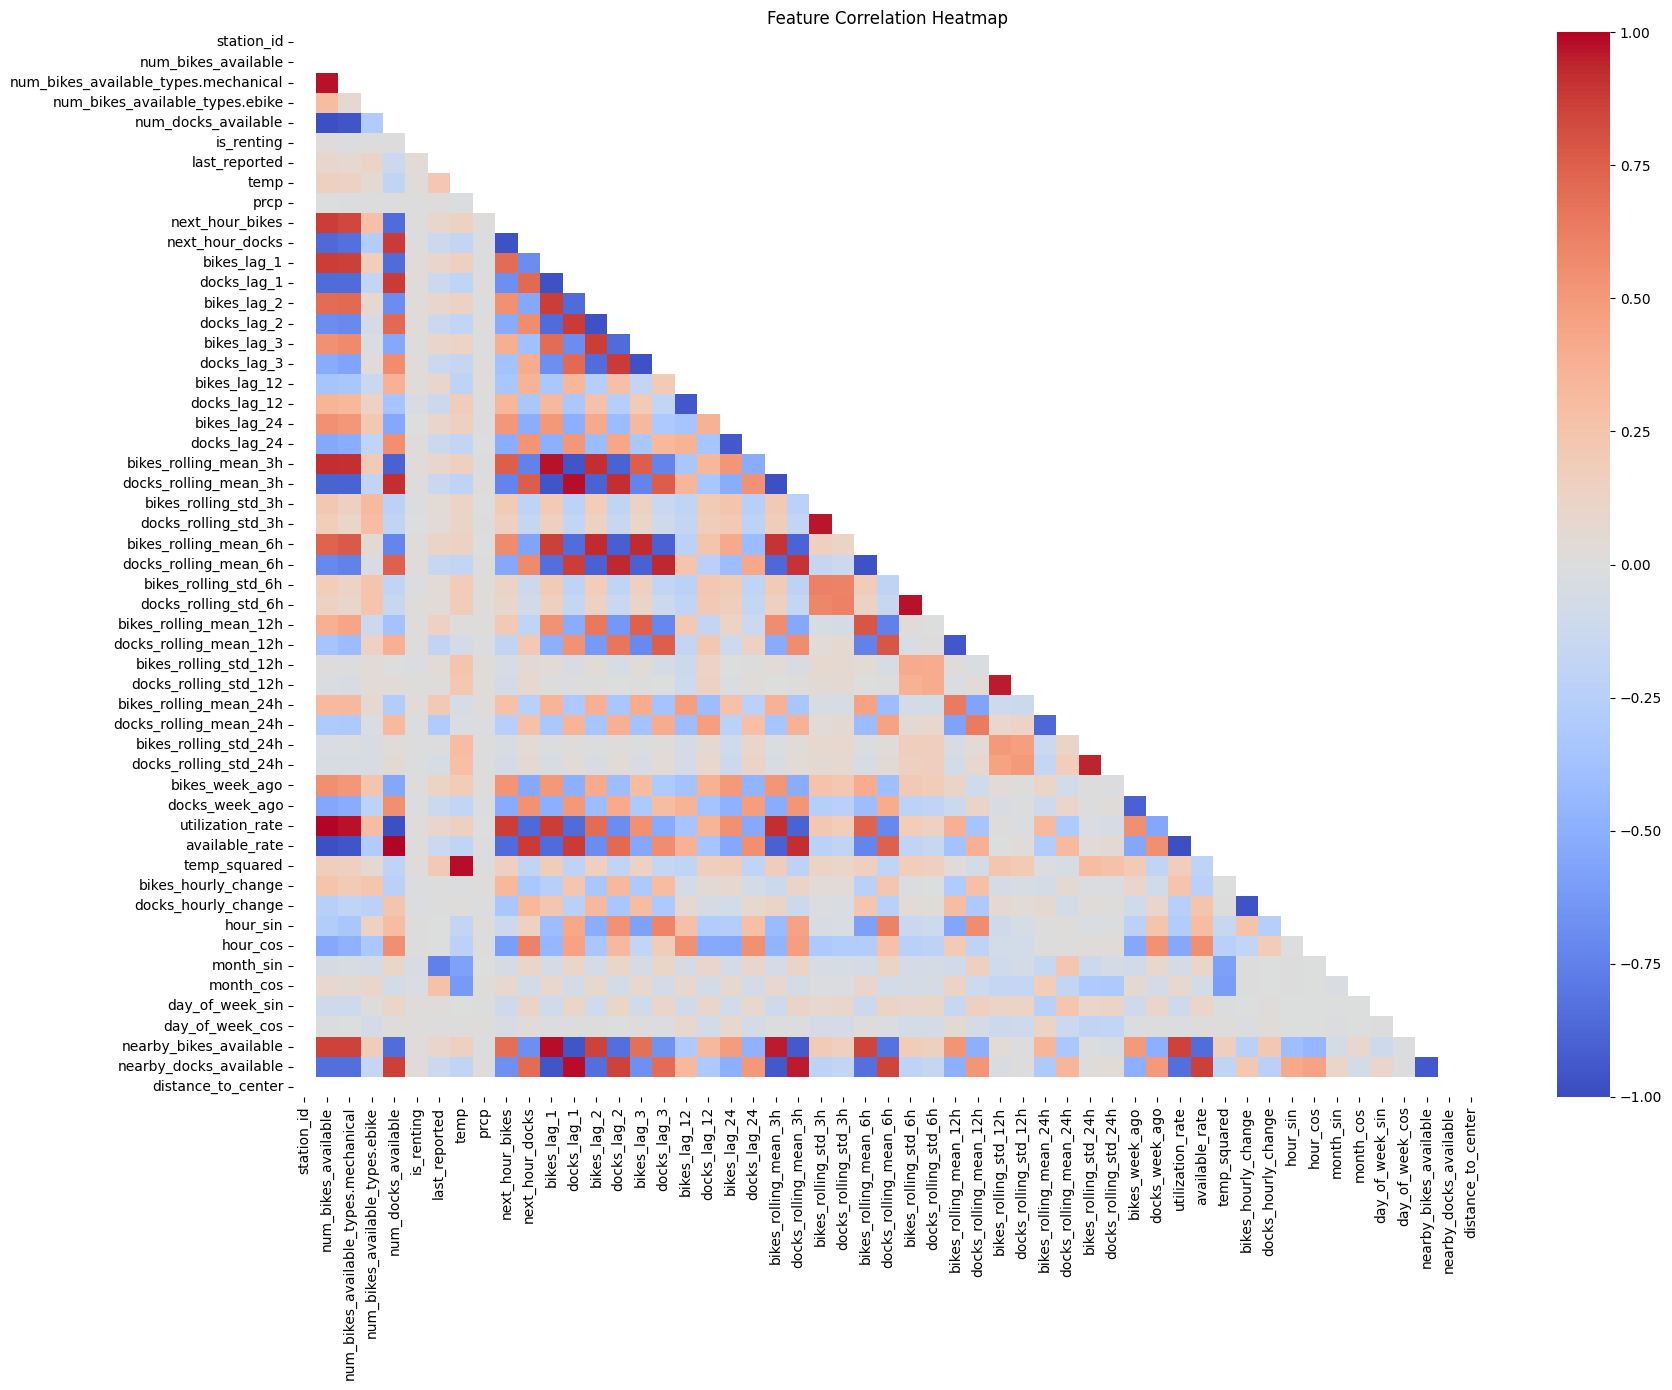

In [37]:
# Check for multicollinearity
plt.figure(figsize=(18, 14))
correlation_matrix = station_data.select_dtypes(include=['float64', 'int64']).corr()

# Focus on correlations with the target variable
target_correlation = correlation_matrix['next_hour_docks'].sort_values(ascending=False)
print("Features most correlated with next hour dock availability:")
print(target_correlation.head(10))

# Plot correlation heatmap
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, vmin=-1, vmax=1, mask=mask)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

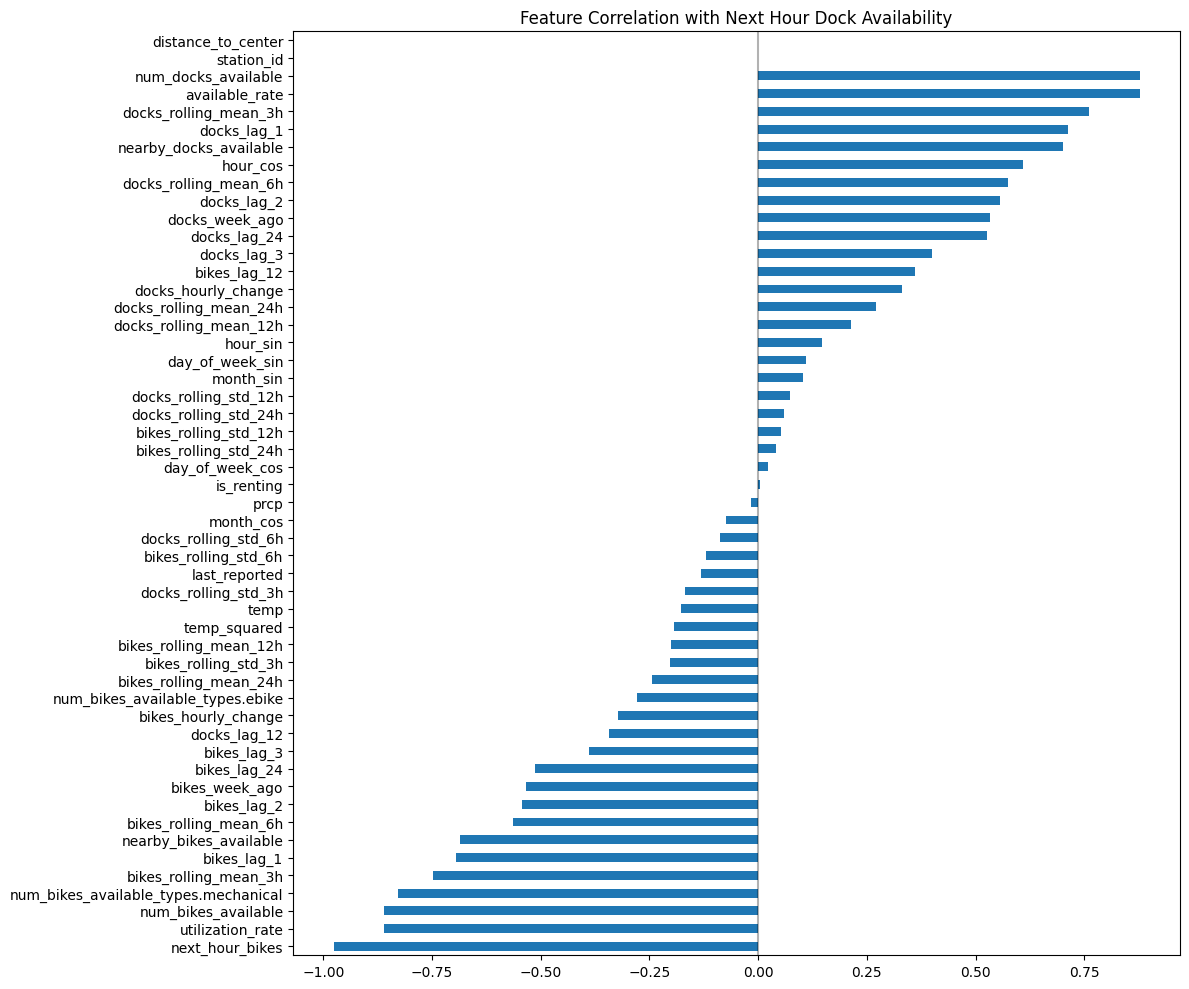

In [38]:
# Plot correlation with target variable
plt.figure(figsize=(12, 10))
target_correlation.drop('next_hour_docks').sort_values().plot(kind='barh')
plt.title('Feature Correlation with Next Hour Dock Availability')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
# Identify highly correlated features (potentially redundant)
threshold = 0.95
high_corr = correlation_matrix.abs() > threshold
high_corr_features = {}
for i in range(len(correlation_matrix.columns)):
    col_name = correlation_matrix.columns[i]
    for j in range(i+1, len(correlation_matrix.columns)):
        if high_corr.iloc[i, j]:
            other_col = correlation_matrix.columns[j]
            if col_name in high_corr_features:
                high_corr_features[col_name].append(other_col)
            else:
                high_corr_features[col_name] = [other_col]

if high_corr_features:
    print("Highly correlated feature groups (correlation > 0.95):")
    for feature, correlated_features in high_corr_features.items():
        print(f"- {feature} is highly correlated with: {', '.join(correlated_features)}")

Highly correlated feature groups (correlation > 0.95):
- num_bikes_available is highly correlated with: num_bikes_available_types.mechanical, num_docks_available, utilization_rate, available_rate
- num_bikes_available_types.mechanical is highly correlated with: num_docks_available, utilization_rate, available_rate
- num_docks_available is highly correlated with: utilization_rate, available_rate
- temp is highly correlated with: temp_squared
- next_hour_bikes is highly correlated with: next_hour_docks
- bikes_lag_1 is highly correlated with: docks_lag_1, bikes_rolling_mean_3h, docks_rolling_mean_3h, nearby_bikes_available, nearby_docks_available
- docks_lag_1 is highly correlated with: bikes_rolling_mean_3h, docks_rolling_mean_3h, nearby_bikes_available, nearby_docks_available
- bikes_lag_2 is highly correlated with: docks_lag_2
- bikes_lag_3 is highly correlated with: docks_lag_3
- bikes_lag_12 is highly correlated with: docks_lag_12
- bikes_rolling_mean_3h is highly correlated with: d

Feature matrix shape: (8423, 65)
Target vector shape: (8423,)


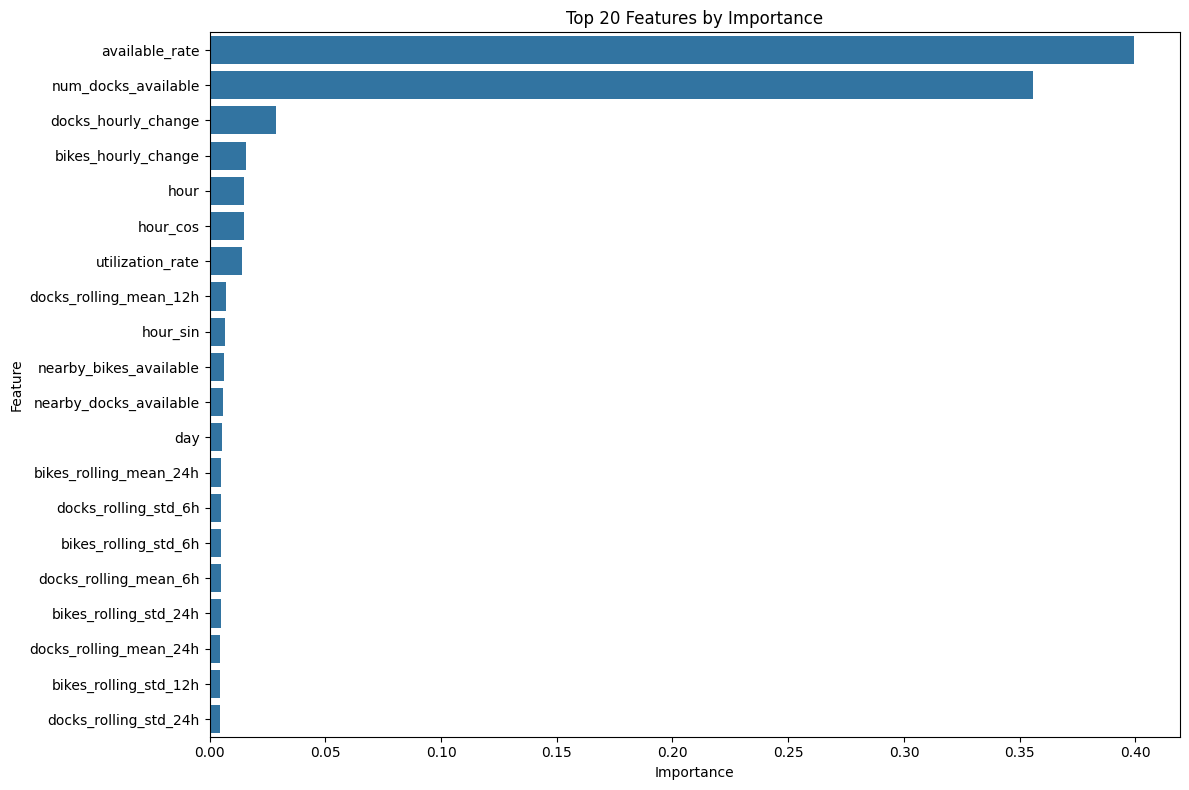

Dataset ready for modeling with the following features: ['num_bikes_available', 'num_bikes_available_types.mechanical', 'num_bikes_available_types.ebike', 'num_docks_available', 'is_renting', 'temp', 'prcp', 'hour', 'day', 'day_of_week', 'month', 'year', 'is_weekend', 'is_holiday', 'is_workday', 'bikes_lag_1', 'docks_lag_1', 'bikes_lag_2', 'docks_lag_2', 'bikes_lag_3', 'docks_lag_3', 'bikes_lag_12', 'docks_lag_12', 'bikes_lag_24', 'docks_lag_24', 'bikes_rolling_mean_3h', 'docks_rolling_mean_3h', 'bikes_rolling_std_3h', 'docks_rolling_std_3h', 'bikes_rolling_mean_6h', 'docks_rolling_mean_6h', 'bikes_rolling_std_6h', 'docks_rolling_std_6h', 'bikes_rolling_mean_12h', 'docks_rolling_mean_12h', 'bikes_rolling_std_12h', 'docks_rolling_std_12h', 'bikes_rolling_mean_24h', 'docks_rolling_mean_24h', 'bikes_rolling_std_24h', 'docks_rolling_std_24h', 'bikes_week_ago', 'docks_week_ago', 'utilization_rate', 'available_rate', 'is_rainy', 'temp_squared', 'rainy_weekend', 'rainy_workday', 'rainy_mornin

In [40]:
# Prepare data for machine learning
# Define features and target
X = station_data.drop(['date', 'station_id', 'last_reported', 'next_hour_bikes', 'next_hour_docks', 'time_of_day', 'temp_bin'], axis=1)
y = station_data['next_hour_docks']  # Target is next hour dock availability

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Print shapes of feature and target matrices
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Optional: Feature importance visualization with Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Features by Importance')
plt.tight_layout()
plt.show()

# Final dataset ready for modeling
print("Dataset ready for modeling with the following features:", X.columns.tolist())

# Save the prepared data
prepared_data = {
    'X': X,
    'y': y,
    'feature_names': X.columns.tolist(),
    'scaler': scaler,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'rf_model': rf
}

## STEP 4: Build and train  regression model to predict hourly dock availability

To ensure the model generalizes across stations, you can include include station_id as a categorical feature (e.g., one-hot encoded or embedded).

Use a machine learning model (e.g., Random Forest, Gradient Boosting) to train on (X_train, y_train) and evaluate on (X_test, y_test). Add a simple baseline model (e.g. ARIMA or autoregressive like). 


Use 2024 months as  test datasets. **Mock Exercise in notebook**: Show model results and key conclusions to Bicing Stakeholders.

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [43]:
# Function to calculate additional evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Model: {model_name}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)
    
    return {
        'model': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

In [44]:
# Load 2024 data for testing
def load_2024_test_data():
    # Collect 2024 data files
    test_files = [f for f in os.listdir() if f.startswith('2024_') and f.endswith('_STATIONS_hourly_mean.csv')]
    
    all_test_data = []
    for filename in test_files:
        try:
            test_df = pd.read_csv(
                filename,
                usecols=sel_cols,
            )
            test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d %H:%M:%S')
            all_test_data.append(test_df)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue
    
    if not all_test_data:
        print("No 2024 test data found. Using train-test split on existing data.")
        return None
    
    test_stations_df = pd.concat(all_test_data, ignore_index=True)
    test_stations_df.sort_values(by=['date', 'station_id'], inplace=True)
    
    # Merge with weather data
    test_start_date = datetime(2024, 1, 1)
    test_end_date = datetime(2024, 3, 31, 23, 59)  # Assuming data through March
    test_weather_data = fetch_hourly_weather_data(barcelona_center, test_start_date, test_end_date)
    
    # Handle weather data
    if test_weather_data is not None:
        test_weather_data['temp'].fillna(method='ffill', inplace=True)
        test_weather_data['prcp'].fillna(0, inplace=True)
        test_weather_data.reset_index(inplace=True)
        test_weather_data.rename(columns={'time': 'date'}, inplace=True)
        test_merged_df = pd.merge(test_stations_df, test_weather_data, on='date', how='left')
    else:
        test_merged_df = test_stations_df
        # Add dummy weather columns
        test_merged_df['temp'] = np.nan
        test_merged_df['prcp'] = np.nan
    
    return test_merged_df

In [45]:
# Try to load 2024 test data
test_data = load_2024_test_data()
# If no 2024 data is available, we'll use train-test split on our existing data
if test_data is None:
    # Use the last 10% of the data as a test set
    time_split_idx = int(len(merged_df) * 0.9)
    train_data = merged_df.iloc[:time_split_idx].copy()
    test_data = merged_df.iloc[time_split_idx:].copy()
    print(f"Using time-based split: {train_data['date'].max()} to {test_data['date'].max()}")
else:
    train_data = merged_df.copy()
    print(f"Using 2024 data as test set: {test_data['date'].min()} to {test_data['date'].max()}")

test_data

Using 2024 data as test set: 2023-11-03 06:00:00 to 2024-03-31 22:00:00


date  station_id  num_bikes_available  \
0       2023-11-03 06:00:00       234.0                    0   
1       2023-11-03 07:00:00       234.0                    0   
2       2023-11-03 08:00:00       234.0                    0   
3       2023-11-03 09:00:00       234.0                    0   
4       2023-11-03 10:00:00       234.0                    0   
...                     ...         ...                  ...   
1118652 2024-03-31 22:00:00       515.0                   13   
1118653 2024-03-31 22:00:00       516.0                    5   
1118654 2024-03-31 22:00:00       517.0                   17   
1118655 2024-03-31 22:00:00       518.0                    1   
1118656 2024-03-31 22:00:00       519.0                    1   

         num_bikes_available_types.mechanical  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
...                                       ...   
1118652                                    12   
1118653                                     2   
1118654                                     7   
1118655                                     0   
1118656                                     0   

         num_bikes_available_types.ebike  num_docks_available  is_renting  \
0                                      0                   27         1.0   
1                                      0                    0         NaN   
2                                      0                    0         NaN   
3                                      0                    0         NaN   
4                                      0                    0         NaN   
...                                  ...                  ...         ...   
1118652                                1                   11         1.0   
1118653                                3                   16         1.0   
1118654                               10                    1         1.0   
1118655                                1                   26         1.0   
1118656                                1                   21         1.0   

         last_reported  temp  prcp  
0         1.698995e+09   NaN   NaN  
1                  NaN   NaN   NaN  
2                  NaN   NaN   NaN  
3                  NaN   NaN   NaN  
4                  NaN   NaN   NaN  
...                ...   ...   ...  
1118652   1.711923e+09  13.0   0.0  
1118653   1.711922e+09  13.0   0.0  
1118654   1.711923e+09  13.0   0.0  
1118655   1.711923e+09  13.0   0.0  
1118656   1.711923e+09  13.0   0.0  

[1118657 rows x 10 columns]

In [46]:
# Feature generation function to ensure consistency between train and test
def generate_features(df, station_info_df):
    # Create a copy to avoid modifying the input
    result_df = df.copy()
    
    # Time-based features
    result_df['hour'] = result_df['date'].dt.hour
    result_df['day'] = result_df['date'].dt.day
    result_df['day_of_week'] = result_df['date'].dt.dayofweek
    result_df['month'] = result_df['date'].dt.month
    result_df['year'] = result_df['date'].dt.year
    result_df['is_weekend'] = result_df['day_of_week'] >= 5
    
    # Define Spanish holidays manually for 2021-2024
    spanish_holidays = [
        # Add all relevant dates from 2021-2024
        "2021-01-01", "2021-01-06", "2021-04-02", "2021-04-05", "2021-05-01",
        "2021-08-15", "2021-10-12", "2021-11-01", "2021-12-06", "2021-12-08", "2021-12-25",
        "2022-01-01", "2022-01-06", "2022-04-15", "2022-04-18", "2022-05-01",
        "2022-08-15", "2022-10-12", "2022-11-01", "2022-12-06", "2022-12-08", "2022-12-25",
        "2023-01-01", "2023-01-06", "2023-04-07", "2023-04-10", "2023-05-01",
        "2023-08-15", "2023-10-12", "2023-11-01", "2023-12-06", "2023-12-08", "2023-12-25",
        "2024-01-01", "2024-01-06", "2024-03-29", "2024-04-01", "2024-05-01",
        "2024-08-15", "2024-10-12", "2024-11-01", "2024-12-06", "2024-12-08", "2024-12-25"
    ]
    
    # Convert to datetime objects
    holiday_dates = pd.to_datetime(spanish_holidays).date
    result_df['is_holiday'] = result_df['date'].dt.date.isin(holiday_dates)
    result_df['is_workday'] = ~(result_df['is_weekend'] | result_df['is_holiday'])
    
    # Cyclic time features
    result_df['hour_sin'] = np.sin(2 * np.pi * result_df['hour'] / 24)
    result_df['hour_cos'] = np.cos(2 * np.pi * result_df['hour'] / 24)
    result_df['day_of_week_sin'] = np.sin(2 * np.pi * result_df['day_of_week'] / 7)
    result_df['day_of_week_cos'] = np.cos(2 * np.pi * result_df['day_of_week'] / 7)
    result_df['month_sin'] = np.sin(2 * np.pi * result_df['month'] / 12)
    result_df['month_cos'] = np.cos(2 * np.pi * result_df['month'] / 12)
    
    # Rush hour indicators
    result_df['is_morning_rush'] = (result_df['hour'] >= 7) & (result_df['hour'] <= 9)
    result_df['is_evening_rush'] = (result_df['hour'] >= 17) & (result_df['hour'] <= 19)
    
    # Weather features
    result_df['is_rainy'] = result_df['prcp'] > 0
    
    # Station capacity and utilization
    result_df = pd.merge(
        result_df,
        station_info_df[['station_id', 'capacity']],
        on='station_id',
        how='left'
    )
    result_df['utilization_rate'] = result_df['num_bikes_available'] / result_df['capacity']
    result_df['available_rate'] = result_df['num_docks_available'] / result_df['capacity']
    
    # Target variable (next hour availability)
    grouped = result_df.groupby('station_id')
    result_df['next_hour_docks'] = grouped['num_docks_available'].shift(-1)
    
    # Create lagged features
    for lag in [1, 2, 3, 12, 24]:
        result_df[f'bikes_lag_{lag}'] = grouped['num_bikes_available'].shift(lag)
        result_df[f'docks_lag_{lag}'] = grouped['num_docks_available'].shift(lag)
    
    # Create rolling statistics
    for window in [3, 6, 12, 24]:
        # Mean
        result_df[f'bikes_rolling_mean_{window}h'] = grouped['num_bikes_available'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
        result_df[f'docks_rolling_mean_{window}h'] = grouped['num_docks_available'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
    
    # Drop rows with NaN values
    result_df.dropna(inplace=True)
    
    return result_df

# Generate features for train and test sets
print("Generating features for training data...")
train_features = generate_features(train_data, station_info_df)
print("Generating features for test data...")
test_features = generate_features(test_data, station_info_df)

Generating features for training data...
Generating features for test data...


In [47]:
train_features

date  station_id  num_bikes_available  \
12120   2021-01-02 00:00:00           1                   19   
12121   2021-01-02 00:00:00           2                   13   
12122   2021-01-02 00:00:00           3                   10   
12123   2021-01-02 00:00:00           4                    2   
12124   2021-01-02 00:00:00           5                   16   
...                     ...         ...                  ...   
4453149 2021-12-31 22:00:00         515                    1   
4453150 2021-12-31 22:00:00         516                   10   
4453151 2021-12-31 22:00:00         517                    3   
4453152 2021-12-31 22:00:00         518                    5   
4453153 2021-12-31 22:00:00         519                    2   

         num_bikes_available_types.mechanical  \
12120                                      17   
12121                                      11   
12122                                      10   
12123                                       2   
12124                                      16   
...                                       ...   
4453149                                     1   
4453150                                     7   
4453151                                     1   
4453152                                     2   
4453153                                     0   

         num_bikes_available_types.ebike  num_docks_available  is_renting  \
12120                                  2                   27         1.0   
12121                                  2                   14         1.0   
12122                                  0                   16         1.0   
12123                                  0                   19         1.0   
12124                                  0                   22         1.0   
...                                  ...                  ...         ...   
4453149                                0                   21         1.0   
4453150                                3                   10         1.0   
4453151                                2                   17         1.0   
4453152                                3                   21         1.0   
4453153                                2                   21         1.0   

         last_reported  temp  prcp  ...  bikes_lag_24  docks_lag_24  \
12120     1.609546e+09   5.5   0.0  ...          40.0           5.0   
12121     1.609546e+09   5.5   0.0  ...          13.0          13.0   
12122     1.609546e+09   5.5   0.0  ...           5.0          20.0   
12123     1.609546e+09   5.5   0.0  ...          12.0           8.0   
12124     1.609546e+09   5.5   0.0  ...           9.0          29.0   
...                ...   ...   ...  ...           ...           ...   
4453149   1.640988e+09  10.1   0.0  ...           3.0          20.0   
4453150   1.640988e+09  10.1   0.0  ...           8.0          12.0   
4453151   1.640988e+09  10.1   0.0  ...           2.0          17.0   
4453152   1.640988e+09  10.1   0.0  ...           4.0          22.0   
4453153   1.640988e+09  10.1   0.0  ...           3.0          21.0   

         bikes_rolling_mean_3h  docks_rolling_mean_3h  bikes_rolling_mean_6h  \
12120                18.666667              27.000000              22.333333   
12121                12.666667              14.000000              11.500000   
12122                 6.000000              19.333333               4.166667   
12123                 1.333333              19.333333               1.166667   
12124                16.000000              22.000000              15.833333   
...                        ...                    ...                    ...   
4453149               1.333333              21.000000               1.166667   
4453150              10.000000              10.000000               9.666667   
4453151               3.000000              17.000000               2.500000   
4453152               4.666667              21.666667               4.000000   
4453153

In [48]:
test_features

date  station_id  num_bikes_available  \
14479   2024-01-01 22:00:00         1.0                   10   
14480   2024-01-01 22:00:00         2.0                    6   
14481   2024-01-01 22:00:00         3.0                    2   
14482   2024-01-01 22:00:00         4.0                    2   
14483   2024-01-01 22:00:00         5.0                    2   
...                     ...         ...                  ...   
1118144 2024-03-31 21:00:00       515.0                   13   
1118145 2024-03-31 21:00:00       516.0                    5   
1118146 2024-03-31 21:00:00       517.0                   17   
1118147 2024-03-31 21:00:00       518.0                    1   
1118148 2024-03-31 21:00:00       519.0                    0   

         num_bikes_available_types.mechanical  \
14479                                       4   
14480                                       5   
14481                                       2   
14482                                       2   
14483                                       2   
...                                       ...   
1118144                                    12   
1118145                                     2   
1118146                                     7   
1118147                                     0   
1118148                                     0   

         num_bikes_available_types.ebike  num_docks_available  is_renting  \
14479                                  6                   35         1.0   
14480                                  1                   19         1.0   
14481                                  0                   23         1.0   
14482                                  0                   18         1.0   
14483                                  0                   36         1.0   
...                                  ...                  ...         ...   
1118144                                1                   11         1.0   
1118145                                3                   15         1.0   
1118146                               10                    1         1.0   
1118147                                1                   26         1.0   
1118148                                0                   23         1.0   

         last_reported  temp  prcp  ...  bikes_lag_24  docks_lag_24  \
14479     1.704147e+09   6.1   0.0  ...          12.0          33.0   
14480     1.704147e+09   6.1   0.0  ...          11.0          15.0   
14481     1.704147e+09   6.1   0.0  ...           5.0          20.0   
14482     1.704147e+09   6.1   0.0  ...           8.0          11.0   
14483     1.704147e+09   6.1   0.0  ...          11.0          28.0   
...                ...   ...   ...  ...           ...           ...   
1118144   1.711919e+09  13.0   0.3  ...           9.0          13.0   
1118145   1.711919e+09  13.0   0.3  ...           2.0          17.0   
1118146   1.711919e+09  13.0   0.3  ...          13.0           4.0   
1118147   1.711919e+09  13.0   0.3  ...           0.0          27.0   
1118148   1.711919e+09  13.0   0.3  ...           6.0          16.0   

         bikes_rolling_mean_3h  docks_rolling_mean_3h  bikes_rolling_mean_6h  \
14479                 9.666667              34.666667               6.666667   
14480                 7.000000              18.666667               7.833333   
14481                 5.333333              19.000000               7.500000   
14482                 2.000000              18.000000               2.666667   
14483                 2.000000              36.000000               2.166667   
...                        ...                    ...                    ...   
1118144              13.333333              10.333333              13.833333   
1118145               5.000000              15.000000               5.333333   
1118146              17.000000               1.000000              17.000000   
1118147               1.000000              26.000000               0.666667   
1118148

In [49]:
# Define features and target
feature_columns = [
    'hour', 'day', 'day_of_week', 'month', 'year', 
    'is_weekend', 'is_holiday', 'is_workday',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
    'is_morning_rush', 'is_evening_rush', 'is_rainy',
    'utilization_rate', 'available_rate',
    'bikes_lag_1', 'bikes_lag_2', 'bikes_lag_3', 'bikes_lag_12', 'bikes_lag_24',
    'docks_lag_1', 'docks_lag_2', 'docks_lag_3', 'docks_lag_12', 'docks_lag_24',
    'bikes_rolling_mean_3h', 'bikes_rolling_mean_6h', 'bikes_rolling_mean_12h', 'bikes_rolling_mean_24h',
    'docks_rolling_mean_3h', 'docks_rolling_mean_6h', 'docks_rolling_mean_12h', 'docks_rolling_mean_24h',
    'station_id', 'temp', 'prcp'
]

# Make sure all features exist in the dataframes
feature_columns = [col for col in feature_columns if col in train_features.columns and col in test_features.columns]

# Define categorical and numerical features
categorical_features = ['station_id']
numerical_features = [col for col in feature_columns if col not in categorical_features]

# Prepare X and y for train and test
X_train = train_features[feature_columns]
y_train = train_features['next_hour_docks']
X_test = test_features[feature_columns]
y_test = test_features['next_hour_docks']

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 4400300 samples
Test set: 1085630 samples


In [50]:
# Preprocess features - scale numerical and one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [51]:
# 1. Baseline model - Historical average by hour and day of week
def baseline_model(X_train, y_train, X_test):
    # Group by station_id, hour, and day_of_week to get average dock availability
    train_grouped = pd.concat([X_train, y_train], axis=1)
    
    baselines = train_grouped.groupby(['station_id', 'hour', 'day_of_week'])['next_hour_docks'].mean()
    
    # Predict for test data
    y_pred = []
    for idx, row in X_test.iterrows():
        station = row['station_id']
        hour = row['hour']
        dow = row['day_of_week']
        
        # Try to get the specific average
        try:
            pred = baselines.loc[(station, hour, dow)]
        except KeyError:
            # If not found, fall back to overall station average
            try:
                pred = train_grouped[train_grouped['station_id'] == station]['next_hour_docks'].mean()
            except:
                # Last resort - overall average
                pred = train_grouped['next_hour_docks'].mean()
        
        y_pred.append(pred)
    
    return np.array(y_pred)

In [52]:
# 2. ARIMA baseline model for one station (for demonstration)
def arima_baseline(train_data, test_data, station_id=64):
    # Filter for a single station
    train_station = train_data[train_data['station_id'] == station_id].sort_values('date')
    test_station = test_data[test_data['station_id'] == station_id].sort_values('date')
    
    # Prepare time series data
    train_ts = pd.Series(train_station['num_docks_available'].values, index=train_station['date'])
    
    # Fit ARIMA model (simple example - in practice you'd need to tune p,d,q)
    try:
        model = ARIMA(train_ts, order=(1, 0, 0))  # Simple AR(1) model
        model_fit = model.fit()
        
        # Predict for test period
        forecast = model_fit.forecast(steps=len(test_station))
        return forecast
    except:
        print(f"ARIMA model failed for station {station_id}. Using mean forecast instead.")
        mean_value = train_ts.mean()
        return np.array([mean_value] * len(test_station))

In [53]:
# Train and evaluate baseline models
print("\nTraining baseline models...")
baseline_predictions = baseline_model(X_train, y_train, X_test)
baseline_results = evaluate_model(y_test, baseline_predictions, "Historical Average Baseline")


Training baseline models...
Model: Historical Average Baseline
MSE: 38.6095
RMSE: 6.2137
MAE: 4.8350
R²: 0.4063
--------------------------------------------------


#### Interpretation
Because these metrics come from a baseline model that likely just uses a simple historical average, it sets a performance floor. Any more advanced model should aim to achieve:

Lower MSE, RMSE, and MAE (meaning smaller errors).

Higher R² (meaning a better explanation of variance in the target variable).

An R² of ~0.41 is not trivial for a baseline, so it suggests that historical averages capture a fair amount of the variability, but there is still significant room for improvement.

In [55]:
# Initialize models
#models = {
#    'Linear Regression': LinearRegression(),
#    'Ridge Regression': Ridge(alpha=1.0),
#    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
#    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
#    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
#    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
#}

In [56]:
# Initialize models with optimized parameters for faster training
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),

    # XGBoost: Reduced n_estimators, increased learning_rate, added n_jobs for parallelism
    'XGBoost': XGBRegressor(
        n_estimators=50,    # Reduced number of trees
        learning_rate=0.2,  # Increased learning rate
        random_state=42,
        n_jobs=-1           # Use all available cores for parallelism
    ),
    
    # LightGBM: Reduced n_estimators, increased learning_rate, added n_jobs for parallelism
    'LightGBM': LGBMRegressor(
        n_estimators=50,    # Reduced number of trees
        learning_rate=0.2,  # Increased learning rate
        random_state=42,
        n_jobs=-1           # Use all available cores for parallelism
    )
}

In [57]:
from tqdm import tqdm

# Train and evaluate all models
results = []
predictions = {}

# Wrap models.items() with tqdm for progress tracking
for name, model in tqdm(models.items(), desc="Training models", unit="model"):
    print(f"\nTraining {name}...")
    
    # Create pipeline with preprocessing
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred
    
    # Evaluate
    model_results = evaluate_model(y_test, y_pred, name)
    results.append(model_results)

Training models:   0%|                                       | 0/4 [00:00<?, ?model/s]


Training Linear Regression...


Training models:  25%|███████▌                      | 1/4 [03:11<09:34, 191.36s/model]

Model: Linear Regression
MSE: 8.5722
RMSE: 2.9278
MAE: 1.9270
R²: 0.8682
--------------------------------------------------

Training Ridge Regression...


Training models:  50%|███████████████               | 2/4 [06:34<06:36, 198.50s/model]

Model: Ridge Regression
MSE: 8.5758
RMSE: 2.9285
MAE: 1.9290
R²: 0.8681
--------------------------------------------------

Training XGBoost...


Training models:  75%|██████████████████████▌       | 3/4 [07:37<02:16, 136.59s/model]

Model: XGBoost
MSE: 8.2172
RMSE: 2.8666
MAE: 1.8846
R²: 0.8736
--------------------------------------------------

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.245268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4332
[LightGBM] [Info] Number of data points in the train set: 4400300, number of used features: 547
[LightGBM] [Info] Start training from score 15.443312


Training models: 100%|██████████████████████████████| 4/4 [08:43<00:00, 130.89s/model]

Model: LightGBM
MSE: 8.2924
RMSE: 2.8796
MAE: 1.8941
R²: 0.8725
--------------------------------------------------



Best performing model: XGBoost
               model       mse      rmse       mae        r2
2            XGBoost  8.217177  2.866562  1.884552  0.873635
3           LightGBM  8.292357  2.879645  1.894065  0.872479
0  Linear Regression  8.572225  2.927836  1.927050  0.868175
1   Ridge Regression  8.575842  2.928454  1.929032  0.868119


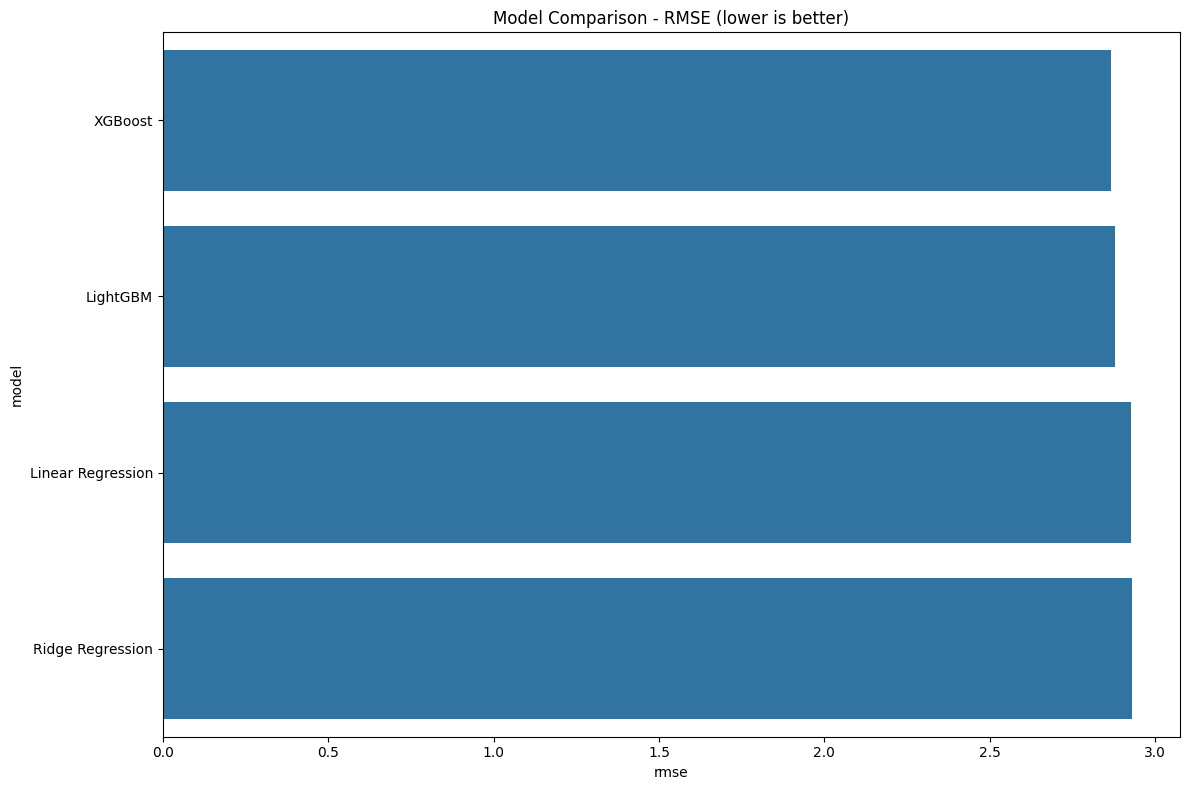

In [58]:
# Compare model performance
results_df = pd.DataFrame(results)
results_df.sort_values('rmse', inplace=True)
best_model = results_df.iloc[0]['model']

print(f"\nBest performing model: {best_model}")
print(results_df)

# Visualize model comparisons
plt.figure(figsize=(12, 8))
sns.barplot(x='rmse', y='model', data=results_df)
plt.title('Model Comparison - RMSE (lower is better)')
plt.tight_layout()
plt.show()

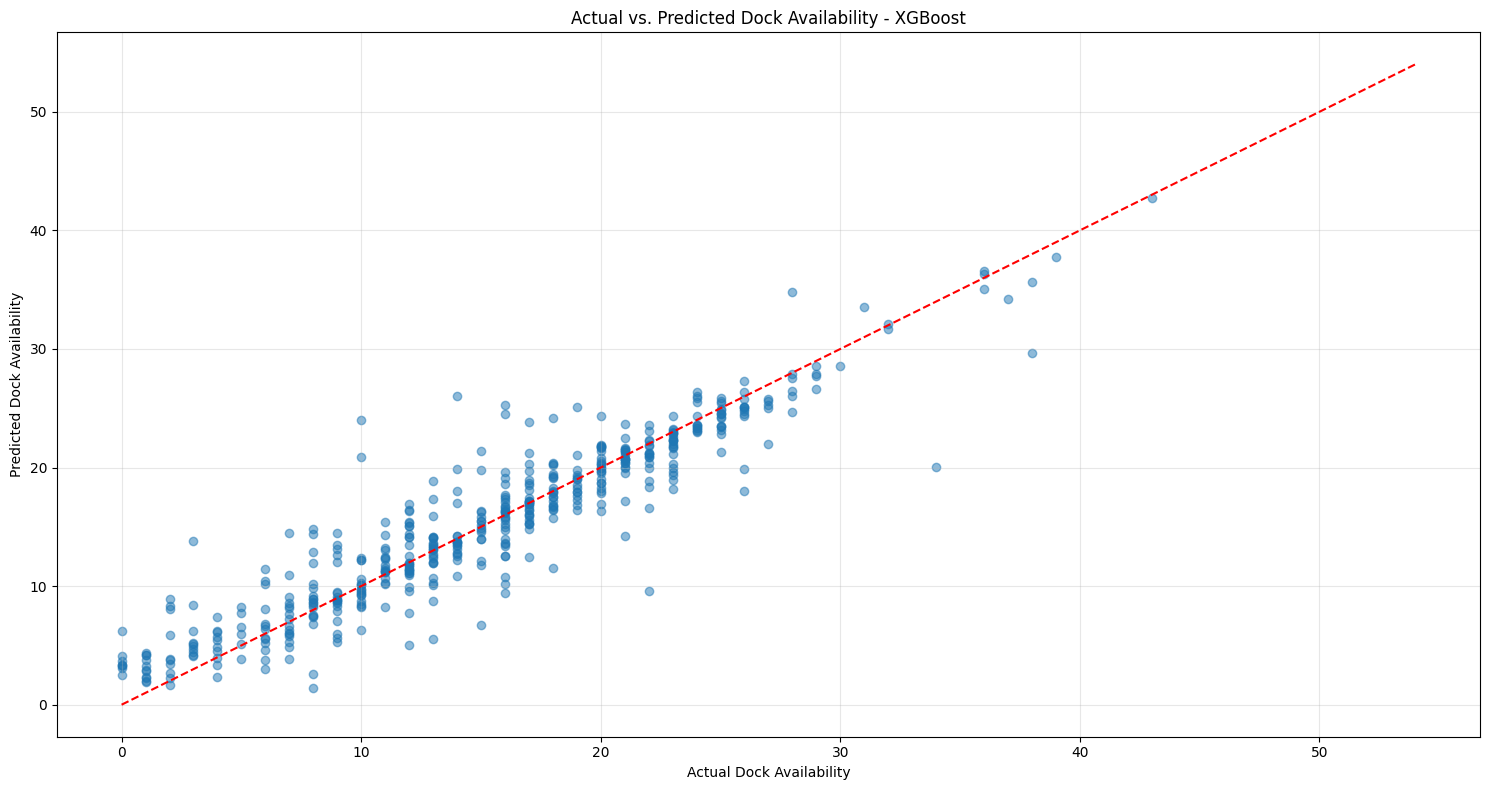

In [59]:
# Visualize predictions vs. actual for the best model
plt.figure(figsize=(15, 8))

# Sample 500 random points to plot
sample_size = min(500, len(y_test))
indices = np.random.choice(len(y_test), sample_size, replace=False)

plt.scatter(y_test.iloc[indices], predictions[best_model][indices], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Dock Availability')
plt.ylabel('Predicted Dock Availability')
plt.title(f'Actual vs. Predicted Dock Availability - {best_model}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

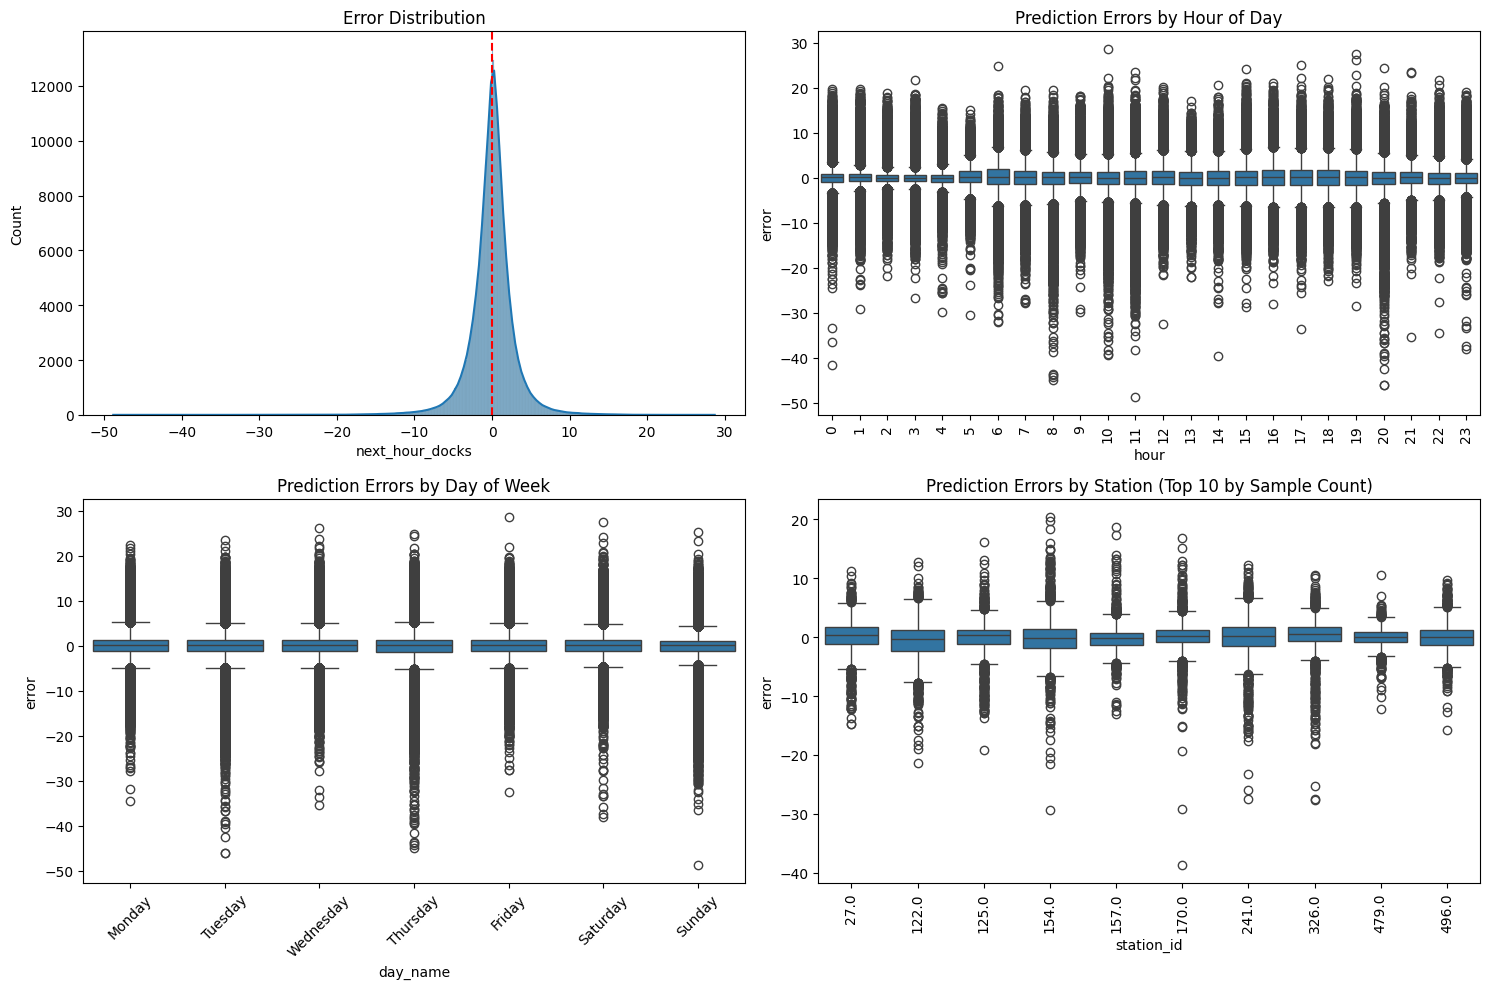

In [60]:
# Error analysis for the best model
best_predictions = predictions[best_model]
errors = y_test - best_predictions

plt.figure(figsize=(15, 10))

# Error distribution
plt.subplot(2, 2, 1)
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.axvline(x=0, color='r', linestyle='--')

# Errors by hour of day
plt.subplot(2, 2, 2)
hourly_errors = pd.DataFrame({'hour': X_test['hour'], 'error': errors})
sns.boxplot(x='hour', y='error', data=hourly_errors)
plt.title('Prediction Errors by Hour of Day')
plt.xticks(rotation=90)

# Errors by day of week
plt.subplot(2, 2, 3)
dow_errors = pd.DataFrame({'day_of_week': X_test['day_of_week'], 'error': errors})
dow_errors['day_name'] = dow_errors['day_of_week'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})
sns.boxplot(x='day_name', y='error', data=dow_errors)
plt.title('Prediction Errors by Day of Week')
plt.xticks(rotation=45)

# Errors by station (top 10 stations with most samples)
plt.subplot(2, 2, 4)
station_counts = X_test['station_id'].value_counts().head(10).index
station_errors = pd.DataFrame({'station_id': X_test['station_id'], 'error': errors})
station_errors = station_errors[station_errors['station_id'].isin(station_counts)]
sns.boxplot(x='station_id', y='error', data=station_errors)
plt.title('Prediction Errors by Station (Top 10 by Sample Count)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

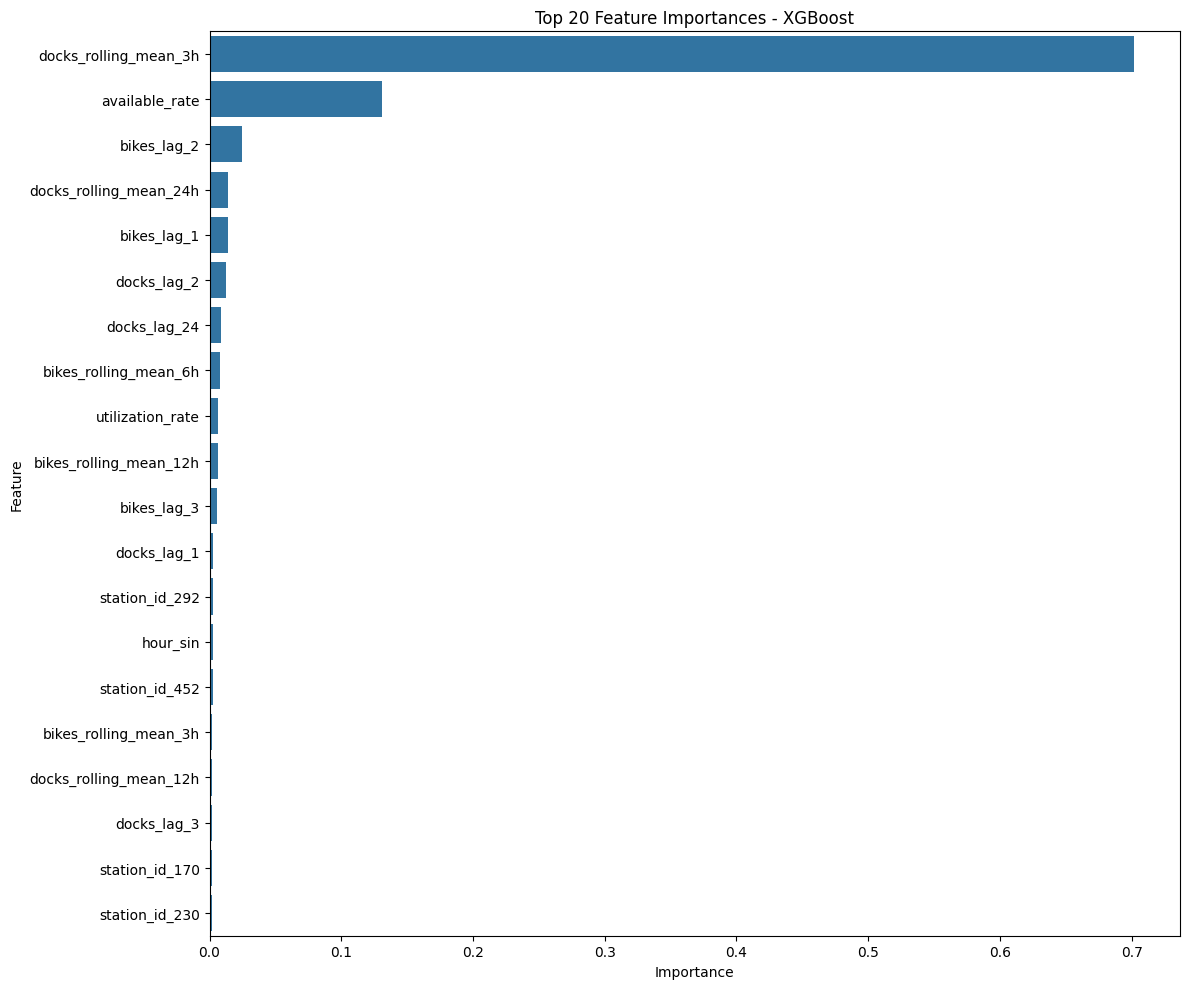

In [61]:
# Feature importance for tree-based models
if best_model in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    # Get the trained model from the pipeline
    best_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', models[best_model])
    ])
    best_pipeline.fit(X_train, y_train)
    
    # Get feature names after preprocessing
    feature_names = (
        numerical_features + 
        list(best_pipeline.named_steps['preprocessor']
             .named_transformers_['cat']
             .get_feature_names_out(categorical_features))
    )
    
    # Get feature importances
    importances = best_pipeline.named_steps['model'].feature_importances_
    
    # Create DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(f'Top 20 Feature Importances - {best_model}')
    plt.tight_layout()
    plt.show()

In [62]:
# Time series forecast visualization for a single station
def visualize_forecast_for_station(station_id=64, days=7):
    # Filter test data for the station
    station_test = test_features[test_features['station_id'] == station_id].sort_values('date')
    
    if len(station_test) == 0:
        print(f"No test data available for station {station_id}")
        return
    
    # Get actual values and predictions from the best model
    actual = station_test['next_hour_docks'].values
    
    # Get station test data indices in the full test set
    station_indices = test_features[test_features['station_id'] == station_id].index
    
    # Get predictions for this station
    station_predictions = {}
    for model_name, all_preds in predictions.items():
        station_preds = np.array([all_preds[test_features.index.get_loc(idx)] for idx in station_indices])
        station_predictions[model_name] = station_preds
    
    # Get dates for the x-axis
    dates = station_test['date'].values
    
    # Limit to the last N days
    if len(dates) > days * 24:
        dates = dates[-days * 24:]
        actual = actual[-days * 24:]
        for model_name in station_predictions:
            station_predictions[model_name] = station_predictions[model_name][-days * 24:]
    
    # Plot forecasts
    plt.figure(figsize=(15, 8))
    plt.plot(dates, actual, 'k-', label='Actual', linewidth=2)
    
    # Plot predictions for the best model and baseline
    plt.plot(dates, station_predictions[best_model], 'b-', label=f'{best_model} Prediction', linewidth=1.5)
    plt.plot(dates, station_predictions['Linear Regression'], 'g--', label='Linear Regression', alpha=0.7)
    
    plt.title(f'Dock Availability Forecast for Station {station_id}')
    plt.xlabel('Date')
    plt.ylabel('Number of Docks Available')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

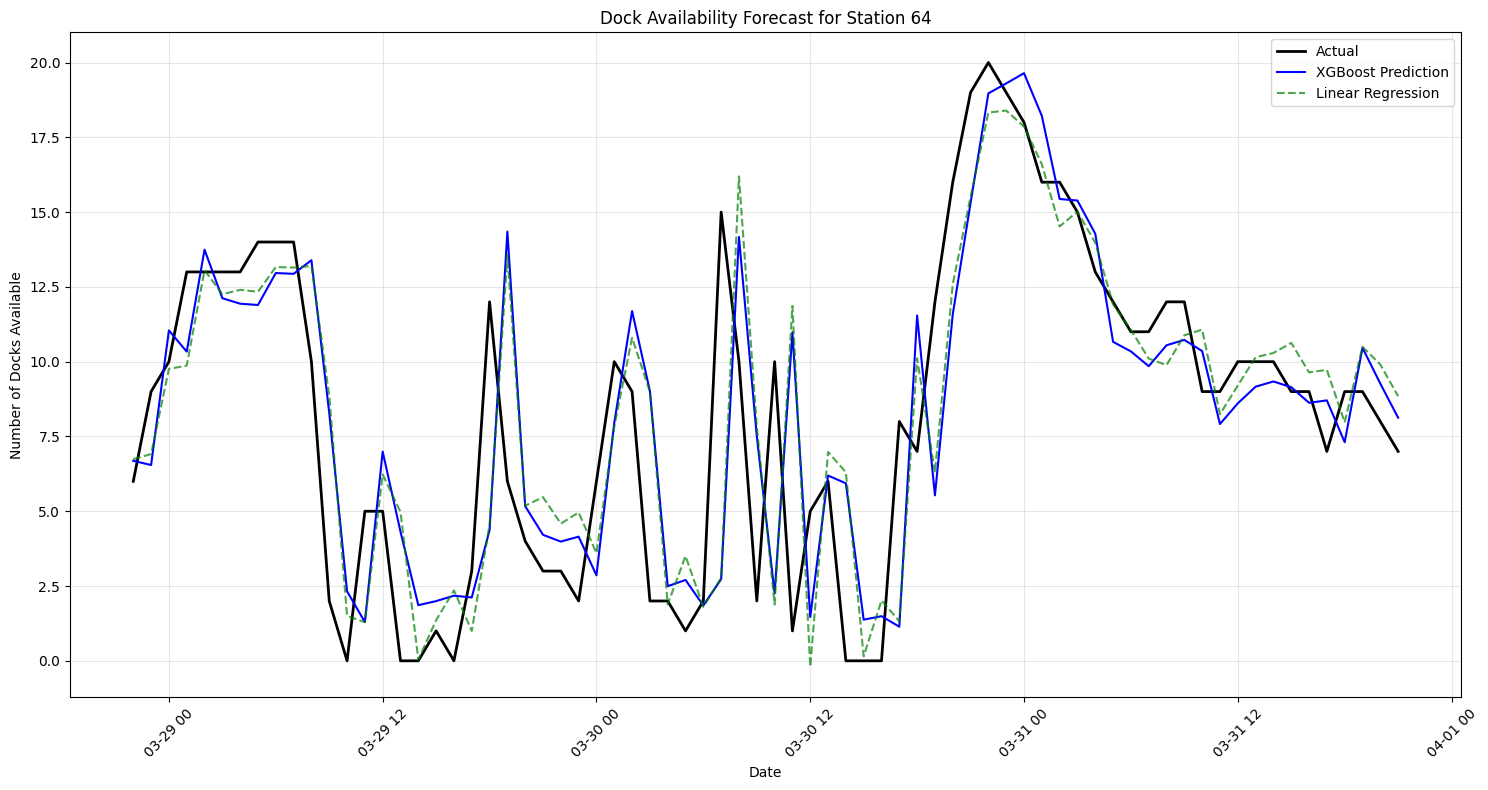

KEY FINDINGS FOR BICING STAKEHOLDERS
Best performing model: XGBoost
RMSE: 2.87 docks
Improvement over baseline: 53.87%


In [64]:
# Visualize forecast for a sample station
visualize_forecast_for_station(station_id=64, days=3)

# Display key findings and recommendations
print("KEY FINDINGS FOR BICING STAKEHOLDERS")
print(f"Best performing model: {best_model}")
print(f"RMSE: {results_df.iloc[0]['rmse']:.2f} docks")
print(f"Improvement over baseline: {(1 - results_df.iloc[0]['rmse']/baseline_results['rmse'])*100:.2f}%")

#### Recommendations:
1. Utilize the model for real-time predictions of station availability
2. Focus on improving prediction accuracy during rush hours when errors are largest
3. Consider rebalancing strategies for stations with consistently poor predictions
4. Update the model regularly with new data to maintain accuracy